In [1]:
#preliminary setup
# %pip install -r requirements.txt
import numpy as np
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F

from sklearn.preprocessing import StandardScaler, MinMaxScaler


#Fetching the data
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split



# set seeds for reproducibility
# random behaviours taken from https://www.geeksforgeeks.org/reproducibility-in-pytorch/
random_seed = 302
# torch.manual_seed(302); np.random.seed(302)

np.random.seed(random_seed)
torch.manual_seed(random_seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(random_seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

X, y = fetch_california_housing(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.125, random_state=random_seed)
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=0.20, random_state=random_seed, )

Training set
size: (14448, 8)
          MedInc   HouseAge   AveRooms   AveBdrms   Population   AveOccup   Latidue   Longitude
mean        3.86      28.65       5.43        1.1     1421.79        3.13      35.64    -119.58
 std        1.89      12.58       2.41       0.43     1110.97       12.39       2.14       2.01
 min         0.5        1.0       0.85       0.33         6.0        0.69      32.54    -124.35
 max        15.0       52.0     141.91      25.64     35682.0     1243.33      41.95    -114.47


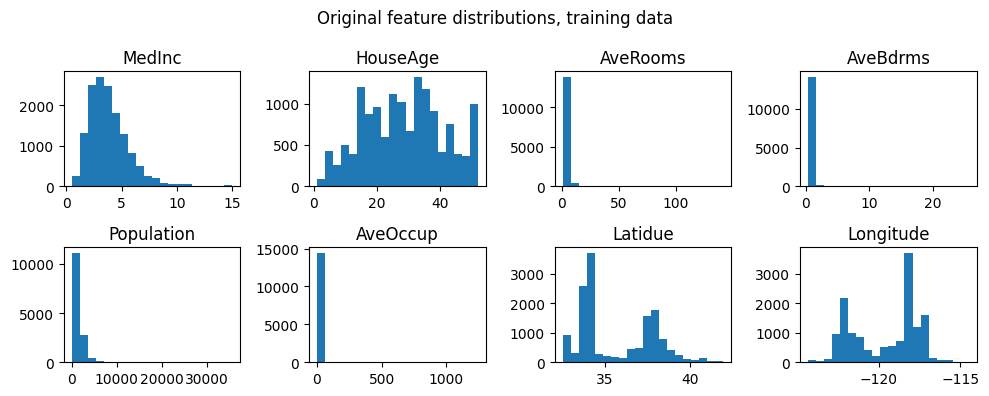

Validation set
size:  (3612, 8)
          MedInc   HouseAge   AveRooms   AveBdrms   Population   AveOccup   Latidue   Longitude
mean        3.89      28.48        5.4       1.09     1431.85        2.93       35.6    -119.54
 std        1.95      12.66       1.82       0.28     1145.46        1.05       2.12       1.98
 min         0.5        1.0       1.38       0.38         3.0        0.75      32.56    -124.25
 max        15.0       52.0      36.48       7.97     15037.0       41.21      41.95    -114.31


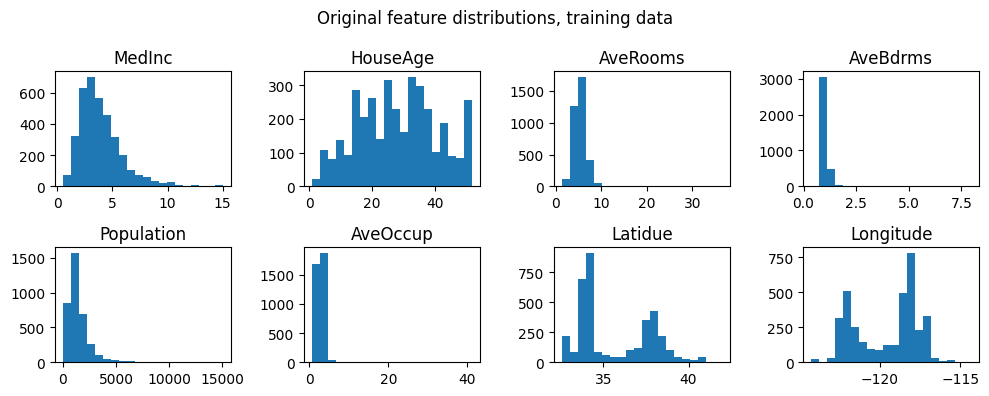

Test set
size:  (2580, 8)
          MedInc   HouseAge   AveRooms   AveBdrms   Population   AveOccup   Latidue   Longitude
mean        3.87      28.77       5.48       1.11     1437.18        2.94      35.62    -119.57
 std         1.9      12.49       3.45        0.8     1228.94        1.29       2.14       1.99
 min         0.5        2.0       0.89        0.5         8.0        1.29      32.55    -124.19
 max        15.0       52.0     132.53      34.07     28566.0        51.4      41.88    -114.49


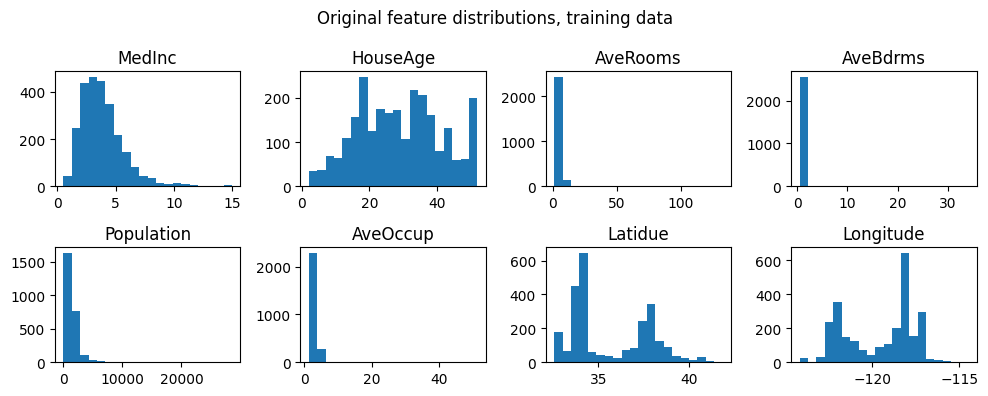

Training set
size: (14448, 8)
          MedInc   HouseAge   AveRooms   AveBdrms   Population   AveOccup   Latidue   Longitude
mean        -0.0       -0.0       -0.0       -0.0        -0.0         0.0        0.0       -0.0
 std         1.0        1.0        1.0        1.0         1.0         1.0        1.0        1.0
 min       -1.78       -2.2       -1.9      -1.76       -1.27        -0.2      -1.45      -2.37
 max         5.9       1.86      56.72      56.66       30.84       100.1       2.95       2.54


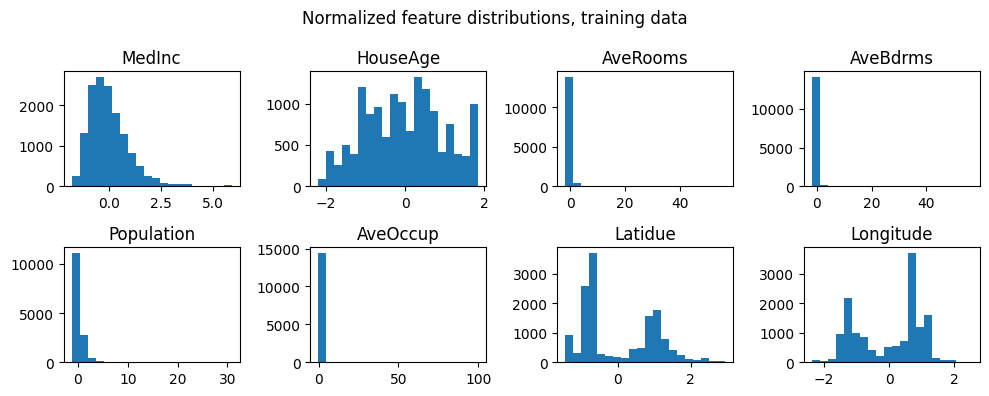

Validation set
size:  (3612, 8)
          MedInc   HouseAge   AveRooms   AveBdrms   Population   AveOccup   Latidue   Longitude
mean        0.02      -0.01      -0.01      -0.03        0.01       -0.02      -0.02       0.02
 std        1.03       1.01       0.76       0.66        1.03        0.08       0.99       0.98
 min       -1.78       -2.2      -1.68      -1.67       -1.28       -0.19      -1.44      -2.32
 max         5.9       1.86       12.9      15.87       12.26        3.07       2.95       2.62


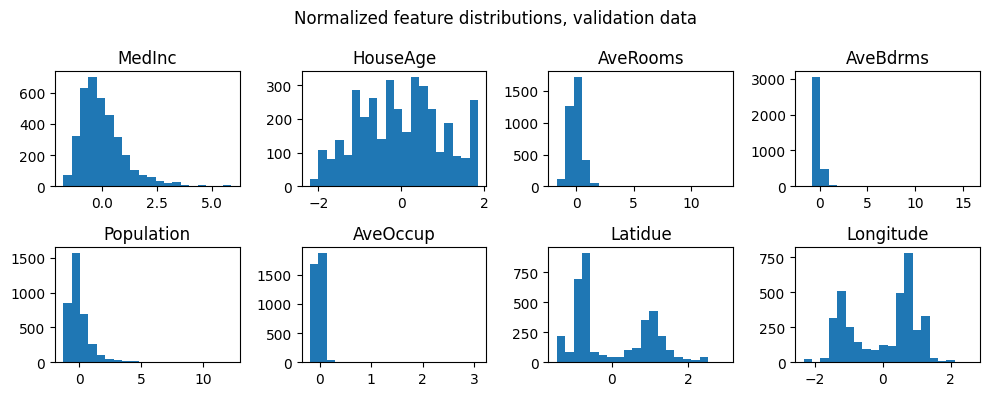

Test set
size:  (2580, 8)
          MedInc   HouseAge   AveRooms   AveBdrms   Population   AveOccup   Latidue   Longitude
mean        0.01       0.01       0.02       0.03        0.01       -0.02      -0.01        0.0
 std        1.01       0.99       1.43       1.84        1.11         0.1        1.0       0.99
 min       -1.78      -2.12      -1.89      -1.38       -1.27       -0.15      -1.45      -2.29
 max         5.9       1.86      52.82      76.13       24.43         3.9       2.92       2.53


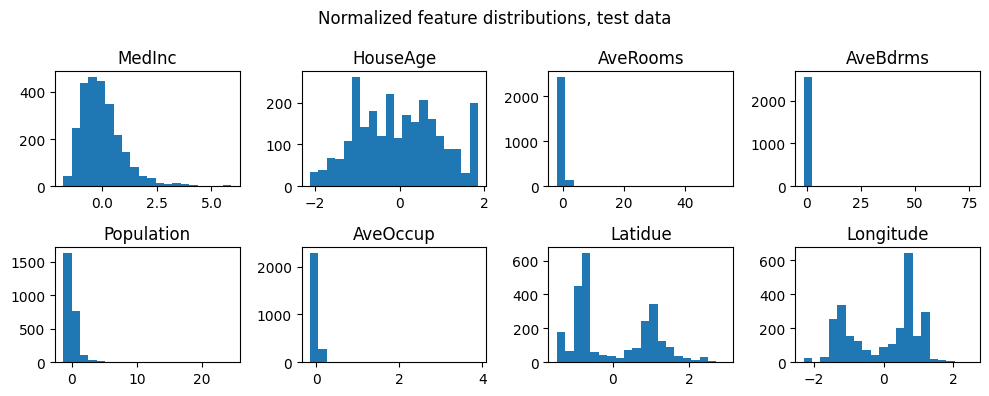

In [2]:
ONLY_TRAINING_SET = False
#a.) Investigating the dataset

all_sets = [X_train,y_train,X_validation,y_validation,X_test,y_test]
all_sets_names = ["Training set","Training targtets","Validation set","Validation targets","Test set","Test targets"]
features = ["MedInc","HouseAge","AveRooms","AveBdrms","Population","AveOccup","Latidue","Longitude"]
if ONLY_TRAINING_SET:
    all_sets = [X_train, y_train]
    all_sets_names = ["Training set","Training targtets"]


#Checking the data, to see what would be good to normalize
for set, name in zip(all_sets[0::2],all_sets_names[0::2]):
    
    print('\033[4m'+'\033[1m'+f"{name}"+'\033[0m'+'\033[0m')
    print(f"size: {str(set.shape) : >10}")
    stats = {"mean":[],
             "std":[],
             "min":[],
             "max":[]}
    fig,axs = plt.subplots(2,len(features)//2,figsize=(10,4),layout = "tight")
    for col,feature in enumerate(features):
        feature_data = set[:,col]
        stats["mean"].append(np.mean(feature_data))
        stats["std"].append(np.std(feature_data))
        stats["min"].append(np.min(feature_data))
        stats["max"].append(np.max(feature_data))
        axs[int(np.floor(col/4))][(col%4)].hist(feature_data,bins=20)
        axs[int(np.floor(col/4))][(col%4)].set_title(feature)
        

    print('\033[1m'+"          "+f"{'   '.join(features)}"+'\033[0m')
    for stat,vals in stats.items():
        x = [str(round(val,2)) for val in vals]
        print('{:>4}{:>12s}{:>11s}{:>11s}{:>11s}{:>12s}{:>12s}{:>11s}{:>11s}'.format(stat,x[0],x[1],x[2],x[3],x[4],x[5],x[6],x[7]))
    
    plt.suptitle("Original feature distributions, training data")
    plt.show()
    fig.savefig(f"./plots/feature distributions_train.png")

#Normalizing data

#fitting the scalers first on the training set and then applying same scalings to the validation and test set
normalized_sets = []
standard_dist_scaler_1 = StandardScaler()
standard_dist_scaler_1.fit(X_train)
X_train_standard = standard_dist_scaler_1.transform(X_train)

min_max_scaler = MinMaxScaler()
min_max_scaler.fit(X_train_standard)
X_train_standart_minmax = min_max_scaler.transform(X_train_standard)

#do another scaling, so it's centered around 0 again
standard_dist_scaler_2 = StandardScaler()
standard_dist_scaler_2.fit(X_train_standart_minmax)

#TODO: Decide normalization on individual level
# now only applied standardization everywhere
names = ["training","validation", "test"]

for i,set in enumerate(all_sets[0::2]):
    norm_set = standard_dist_scaler_1.transform(set)
    #norm_set = min_max_scaler.transform(norm_set)
    #norm_set = standard_dist_scaler_2.transform(norm_set)
    normalized_sets.append(norm_set)

    # new_set = np.zeros_like(set)
    # for col in range(len(features)):

    #     norm_feature = np.reshape(set[:,col],(1,len(set[:,col])))
        
    #     #Standard gauss distribution
    #     norm_feature = (norm_feature-np.mean(norm_feature))/np.std(norm_feature)
    #     all_sets[i*2][:,col] = norm_feature
        
    #     #min-max scaling into -1 +1 range
    #     norm_feature = (norm_feature-np.min(np.abs(norm_feature)))/(np.max(np.abs(norm_feature))-np.min(np.abs(norm_feature)))
    #     new_set[:,col] = norm_feature

    # normalized_sets.append(new_set)

for i,(set,name) in enumerate(zip(normalized_sets,all_sets_names[0::2])):
    print('\033[4m'+'\033[1m'+f"{name}"+'\033[0m'+'\033[0m')
    print(f"size: {str(set.shape) : >10}")
    stats = {"mean":[],
                "std":[],
                "min":[],
                "max":[]}
    fig,axs = plt.subplots(2,len(features)//2,figsize=(10,4),layout = "tight")
    for col,feature in enumerate(features):
        feature_data = set[:,col]
        stats["mean"].append(np.mean(feature_data))
        stats["std"].append(np.std(feature_data))
        stats["min"].append(np.min(feature_data))
        stats["max"].append(np.max(feature_data))
        axs[int(np.floor(col/4))][(col%4)].hist(feature_data,bins=20)
        axs[int(np.floor(col/4))][(col%4)].set_title(feature)
        

    print('\033[1m'+"          "+f"{'   '.join(features)}"+'\033[0m')
    for stat,vals in stats.items():
        x = [str(round(val,2)) for val in vals]
        print('{:>4}{:>12s}{:>11s}{:>11s}{:>11s}{:>12s}{:>12s}{:>11s}{:>11s}'.format(stat,x[0],x[1],x[2],x[3],x[4],x[5],x[6],x[7]))

    plt.suptitle(f"Normalized feature distributions, {names[i]} data")
    plt.show()
    fig.savefig(f"./plots/normalized feature distributions_{names[i]}.png")

In [3]:
len(all_sets_names)

6

## Networks

In [4]:
from models import NeuralNet_deep, NeuralNet_wide, NeuralNet_default, NeuralNet_deep_wider, NeuralNet_deeper_wide

def train_model(model, train_loader, val_loader=None, device='cpu', optimizer=None, num_epochs=30, scheduler=None):
    torch.manual_seed(302); np.random.seed(302)
    loss_fn = nn.MSELoss()
    #saves losses on every batch
    train_losses_all = []
    val_losses_all = []
    model.to(device)
    for epoch in range(num_epochs):
        train_losses_epoch = []
        print('-'*20, f'Epoch {epoch}', '-'*20)
        # Train one epoch
        model.train()
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)

            if optimizer is not None:
                optimizer.zero_grad()
            predict = model(data)
            loss = loss_fn(predict, target)
            loss.backward()
            if optimizer is not None:
                optimizer.step()

            train_losses_epoch.append(loss.item())
        if scheduler is not None:
            scheduler.step() # update learning rate based on the schedule
        train_loss_epoch_mean =np.mean(train_losses_epoch)
        train_losses_all.append(train_loss_epoch_mean)
        print(f'Average Training Loss for epoch(over all batches) {np.mean(train_losses_epoch)}')
        

        # correct = 0
        if val_loader is not None:
            # Evaluate on validation set
            model.eval()
            val_loss = 0
            with torch.no_grad():
                for data, target in val_loader:
                    data, target = data.to(device), target.to(device)
                    predict = model(data)
                    val_loss += F.mse_loss(predict, target, reduction='sum').item()  # sum up batch loss
                    # correct += (predict == target).sum().item()

            val_loss /= len(val_loader.dataset)
            # avg_correct = correct / len(val_loader.dataset)
            val_losses_all.append(val_loss)
            # val_accuracies.append(avg_correct)

            print(f'Validation loss for epoch: {val_loss:.4f})\n')
    
    return train_losses_all, val_losses_all


NeuralNet_deep
-------------------- Epoch 0 --------------------
Average Training Loss for epoch(over all batches) 0.7094007992243345
Validation loss for epoch: 0.4209)

-------------------- Epoch 1 --------------------
Average Training Loss for epoch(over all batches) 0.3750180832843865
Validation loss for epoch: 0.3771)

-------------------- Epoch 2 --------------------
Average Training Loss for epoch(over all batches) 0.3497100639099305
Validation loss for epoch: 0.3454)

-------------------- Epoch 3 --------------------
Average Training Loss for epoch(over all batches) 0.32581814001025877
Validation loss for epoch: 0.3338)

-------------------- Epoch 4 --------------------
Average Training Loss for epoch(over all batches) 0.3153238347113396
Validation loss for epoch: 0.3259)

-------------------- Epoch 5 --------------------
Average Training Loss for epoch(over all batches) 0.29972972776905626
Validation loss for epoch: 0.3240)

-------------------- Epoch 6 --------------------
Ave

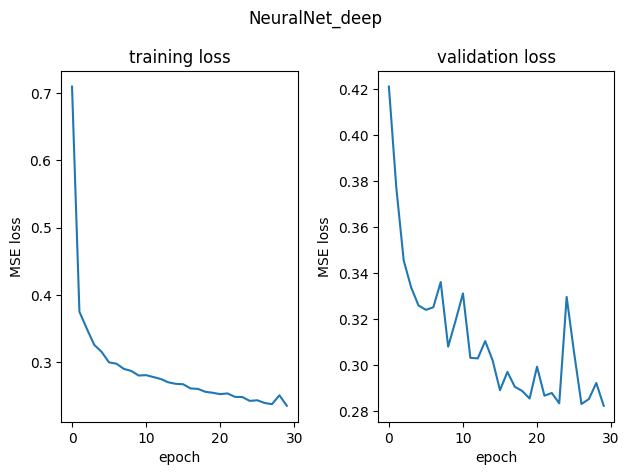

NeuralNet_wide
-------------------- Epoch 0 --------------------
Average Training Loss for epoch(over all batches) 0.6737991249007461
Validation loss for epoch: 0.4371)

-------------------- Epoch 1 --------------------
Average Training Loss for epoch(over all batches) 0.3863155364957267
Validation loss for epoch: 0.4079)

-------------------- Epoch 2 --------------------
Average Training Loss for epoch(over all batches) 0.3658421697935699
Validation loss for epoch: 0.3726)

-------------------- Epoch 3 --------------------
Average Training Loss for epoch(over all batches) 0.34847544361960836
Validation loss for epoch: 0.3519)

-------------------- Epoch 4 --------------------
Average Training Loss for epoch(over all batches) 0.33087381005155303
Validation loss for epoch: 0.3414)

-------------------- Epoch 5 --------------------
Average Training Loss for epoch(over all batches) 0.3196010756083822
Validation loss for epoch: 0.3399)

-------------------- Epoch 6 --------------------
Ave

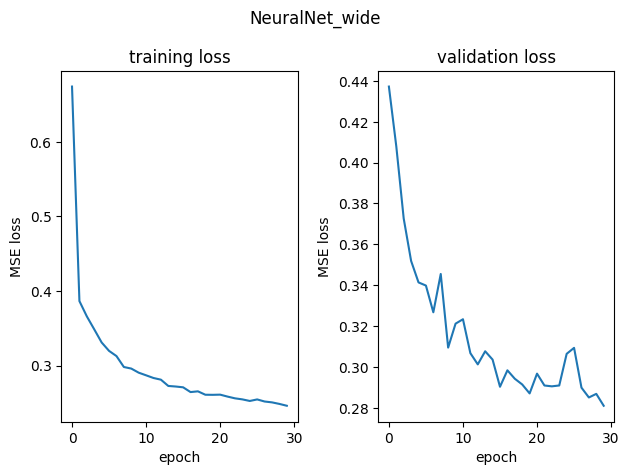

NeuralNet_default
-------------------- Epoch 0 --------------------
Average Training Loss for epoch(over all batches) 0.8730954519613127
Validation loss for epoch: 0.4573)

-------------------- Epoch 1 --------------------
Average Training Loss for epoch(over all batches) 0.4058453642425284
Validation loss for epoch: 0.4082)

-------------------- Epoch 2 --------------------
Average Training Loss for epoch(over all batches) 0.3741868763700523
Validation loss for epoch: 0.3924)

-------------------- Epoch 3 --------------------
Average Training Loss for epoch(over all batches) 0.35881379734625857
Validation loss for epoch: 0.3700)

-------------------- Epoch 4 --------------------
Average Training Loss for epoch(over all batches) 0.3478389047086239
Validation loss for epoch: 0.3584)

-------------------- Epoch 5 --------------------
Average Training Loss for epoch(over all batches) 0.33727906611377156
Validation loss for epoch: 0.3535)

-------------------- Epoch 6 --------------------


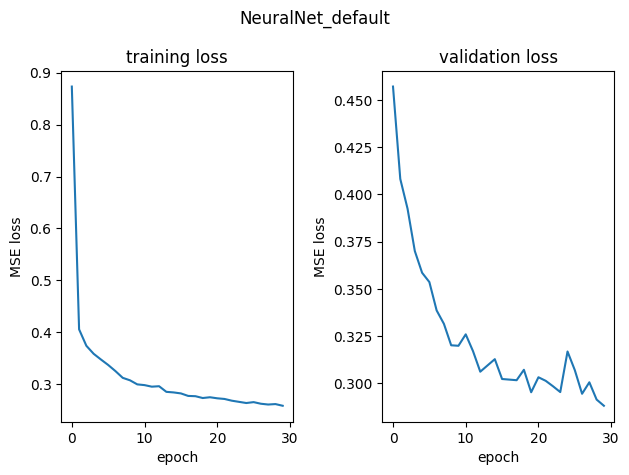

NeuralNet_deep_wider
-------------------- Epoch 0 --------------------
Average Training Loss for epoch(over all batches) 0.6137206698314542
Validation loss for epoch: 0.4113)

-------------------- Epoch 1 --------------------
Average Training Loss for epoch(over all batches) 0.3708368618601719
Validation loss for epoch: 0.3618)

-------------------- Epoch 2 --------------------
Average Training Loss for epoch(over all batches) 0.3407707481224716
Validation loss for epoch: 0.3609)

-------------------- Epoch 3 --------------------
Average Training Loss for epoch(over all batches) 0.33196597915571346
Validation loss for epoch: 0.3320)

-------------------- Epoch 4 --------------------
Average Training Loss for epoch(over all batches) 0.3145153537491518
Validation loss for epoch: 0.3251)

-------------------- Epoch 5 --------------------
Average Training Loss for epoch(over all batches) 0.2996037000444083
Validation loss for epoch: 0.3092)

-------------------- Epoch 6 -------------------

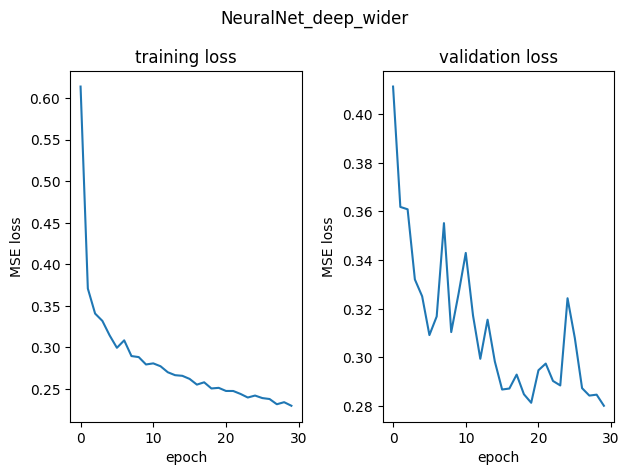

NeuralNet_deeper_wide
-------------------- Epoch 0 --------------------
Average Training Loss for epoch(over all batches) 0.6393288526255473
Validation loss for epoch: 0.4154)

-------------------- Epoch 1 --------------------
Average Training Loss for epoch(over all batches) 0.3762981126793718
Validation loss for epoch: 0.3749)

-------------------- Epoch 2 --------------------
Average Training Loss for epoch(over all batches) 0.3556541241375746
Validation loss for epoch: 0.3843)

-------------------- Epoch 3 --------------------
Average Training Loss for epoch(over all batches) 0.3426746984498691
Validation loss for epoch: 0.3397)

-------------------- Epoch 4 --------------------
Average Training Loss for epoch(over all batches) 0.3237565525733264
Validation loss for epoch: 0.3360)

-------------------- Epoch 5 --------------------
Average Training Loss for epoch(over all batches) 0.30568823284279983
Validation loss for epoch: 0.3179)

-------------------- Epoch 6 ------------------

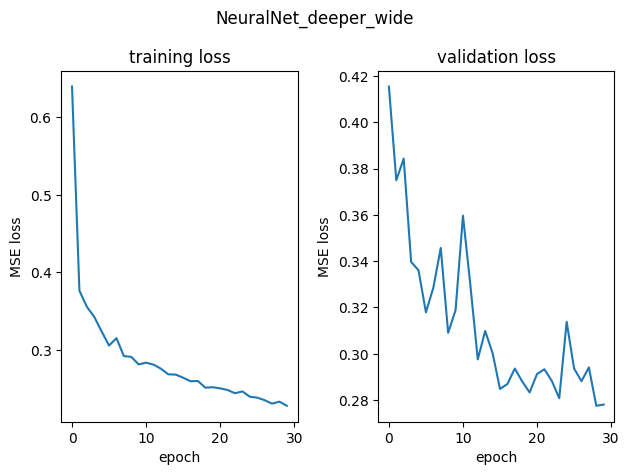

best model: NeuralNet_deeper_wide, best epoch: 28, best validation loss: 0.2775191000001639


In [5]:
#evaluation of the different models
from torch.utils.data import TensorDataset, DataLoader

X_train_norm = normalized_sets[0]
X_val_norm = normalized_sets[1]
X_test_norm = normalized_sets[2]

random_seed = 302
torch.manual_seed(302); np.random.seed(302)

X_train_torch = torch.tensor(X_train_norm,dtype=torch.float32)
y_train_torch = torch.tensor(y_train.reshape((len(y_train),1)),dtype=torch.float32)
X_validation_torch = torch.tensor(X_val_norm,dtype=torch.float32)
y_validation_torch = torch.tensor(y_validation.reshape((len(y_validation),1)),dtype=torch.float32)
X_test_torch = torch.tensor(X_test_norm,dtype=torch.float32)
y_test_torch = torch.tensor(y_test.reshape((len(y_test),1)),dtype=torch.float32)

train_dataset = TensorDataset(X_train_torch,y_train_torch)
validation_dataset = TensorDataset(X_validation_torch,y_validation_torch)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, worker_init_fn=lambda _: np.random.seed(random_seed))
val_loader = DataLoader(validation_dataset, batch_size=32, shuffle=True, worker_init_fn=lambda _: np.random.seed(random_seed))

device = 'cuda' if torch.cuda.is_available() else 'cpu' # if you have a gpu, you can move the model onto it like this
all_models = NeuralNet_deep(), NeuralNet_wide(), NeuralNet_default(), NeuralNet_deep_wider(), NeuralNet_deeper_wide()

best_loss = 100
for model in all_models:
    print(model._get_name())
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    train_loss, val_loss = train_model(model,train_loader,val_loader,device, optimizer=optimizer, num_epochs=30)

    if np.min(val_loss) < best_loss:
        best_model = model
        best_epoch = np.argmin(val_loss)
        best_loss = np.min(val_loss)

    fig,axs = plt.subplots(1,2,layout="tight")
    axs[0].plot(train_loss)
    axs[0].set_title("training loss")
    # axs[0].set_ylim([max(train_loss),max(train_loss)])
    axs[0].set_xlabel("epoch")
    axs[0].set_ylabel("MSE loss")
    
    axs[1].plot(val_loss)
    axs[1].set_title("validation loss")
    # axs[1].set_ylim([max(val_loss),max(val_loss)])
    axs[1].set_xlabel("epoch")
    axs[1].set_ylabel("MSE loss")
    plt.suptitle(f"{model._get_name()}")
    plt.show()

print(f"best model: {best_model._get_name()}, best epoch: {best_epoch}, best validation loss: {best_loss}")

## c) Optimizers and Scheduling

Optimizer: SGD with learning rate: 0.001 and scheduler: StepLR 

-------------------- Epoch 0 --------------------
Average Training Loss for epoch(over all batches) 2.468844077096576
Validation loss for epoch: 1.1848)

-------------------- Epoch 1 --------------------
Average Training Loss for epoch(over all batches) 0.9563000951852418
Validation loss for epoch: 0.8098)

-------------------- Epoch 2 --------------------
Average Training Loss for epoch(over all batches) 0.7014009858918401
Validation loss for epoch: 0.6681)

-------------------- Epoch 3 --------------------
Average Training Loss for epoch(over all batches) 0.6287258914877883
Validation loss for epoch: 0.6318)

-------------------- Epoch 4 --------------------
Average Training Loss for epoch(over all batches) 0.5988203682401011
Validation loss for epoch: 0.6065)

-------------------- Epoch 5 --------------------
Average Training Loss for epoch(over all batches) 0.5722866538021945
Validation loss for epoch: 0.5826)

------

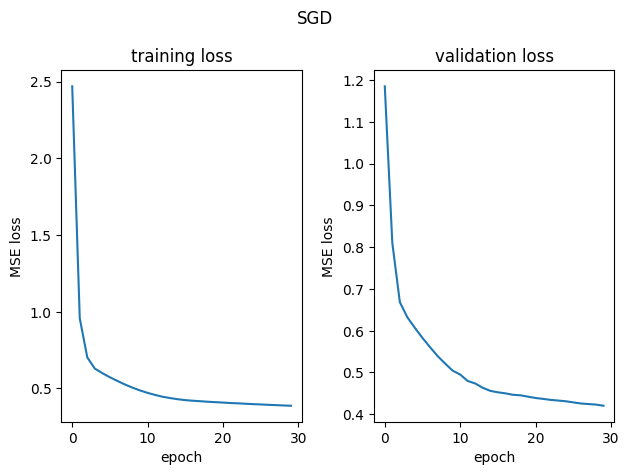

Optimizer: SGD with learning rate: 0.001 and scheduler: MultiStepLR 

-------------------- Epoch 0 --------------------
Average Training Loss for epoch(over all batches) 2.206996276183466
Validation loss for epoch: 1.1274)

-------------------- Epoch 1 --------------------
Average Training Loss for epoch(over all batches) 0.8935887723238067
Validation loss for epoch: 0.7640)

-------------------- Epoch 2 --------------------
Average Training Loss for epoch(over all batches) 0.6867544336854357
Validation loss for epoch: 0.6668)

-------------------- Epoch 3 --------------------
Average Training Loss for epoch(over all batches) 0.6313691814718521
Validation loss for epoch: 0.6295)

-------------------- Epoch 4 --------------------
Average Training Loss for epoch(over all batches) 0.5967065783596672
Validation loss for epoch: 0.5986)

-------------------- Epoch 5 --------------------
Average Training Loss for epoch(over all batches) 0.5717733440739391
Validation loss for epoch: 0.5835)

-

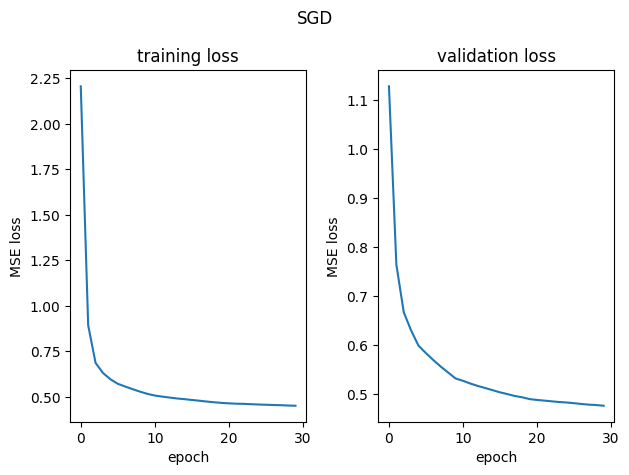

Optimizer: SGD with learning rate: 0.001 and scheduler: CosineAnnealingLR 

-------------------- Epoch 0 --------------------
Average Training Loss for epoch(over all batches) 2.206996276183466
Validation loss for epoch: 1.1274)

-------------------- Epoch 1 --------------------
Average Training Loss for epoch(over all batches) 0.8939873305833446
Validation loss for epoch: 0.7645)

-------------------- Epoch 2 --------------------
Average Training Loss for epoch(over all batches) 0.6873827289163539
Validation loss for epoch: 0.6674)

-------------------- Epoch 3 --------------------
Average Training Loss for epoch(over all batches) 0.6323259997354672
Validation loss for epoch: 0.6307)

-------------------- Epoch 4 --------------------
Average Training Loss for epoch(over all batches) 0.5986101423283067
Validation loss for epoch: 0.6010)

-------------------- Epoch 5 --------------------
Average Training Loss for epoch(over all batches) 0.5680121834497008
Validation loss for epoch: 0.57

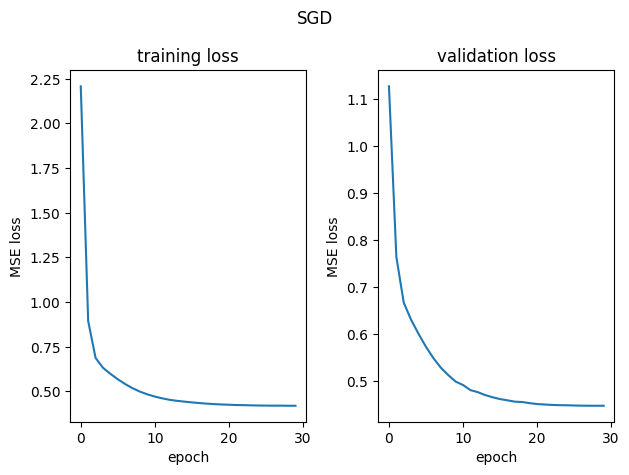

Optimizer: SGD with learning rate: 0.001 and scheduler: CosineAnnealingWarmRestarts 

-------------------- Epoch 0 --------------------
Average Training Loss for epoch(over all batches) 2.206996276183466
Validation loss for epoch: 1.1274)

-------------------- Epoch 1 --------------------
Average Training Loss for epoch(over all batches) 0.8951946629491527
Validation loss for epoch: 0.7662)

-------------------- Epoch 2 --------------------
Average Training Loss for epoch(over all batches) 0.6893119267394058
Validation loss for epoch: 0.6693)

-------------------- Epoch 3 --------------------
Average Training Loss for epoch(over all batches) 0.6351977431470841
Validation loss for epoch: 0.6344)

-------------------- Epoch 4 --------------------
Average Training Loss for epoch(over all batches) 0.6042254318573833
Validation loss for epoch: 0.6082)

-------------------- Epoch 5 --------------------
Average Training Loss for epoch(over all batches) 0.5779657593672782
Validation loss for e

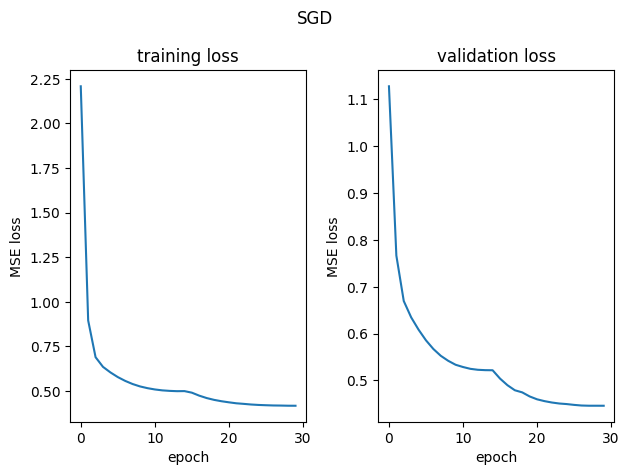

Optimizer: SGD with Momentum with learning rate: 0.001 and scheduler: StepLR 

-------------------- Epoch 0 --------------------
Average Training Loss for epoch(over all batches) 0.9069776003603387
Validation loss for epoch: 0.5351)

-------------------- Epoch 1 --------------------
Average Training Loss for epoch(over all batches) 0.4598938719888704
Validation loss for epoch: 0.4568)

-------------------- Epoch 2 --------------------
Average Training Loss for epoch(over all batches) 0.41444123355028906
Validation loss for epoch: 0.4315)

-------------------- Epoch 3 --------------------
Average Training Loss for epoch(over all batches) 0.39046493794076736
Validation loss for epoch: 0.4056)

-------------------- Epoch 4 --------------------
Average Training Loss for epoch(over all batches) 0.3738936392540953
Validation loss for epoch: 0.3877)

-------------------- Epoch 5 --------------------
Average Training Loss for epoch(over all batches) 0.3574860028724755
Validation loss for epoch

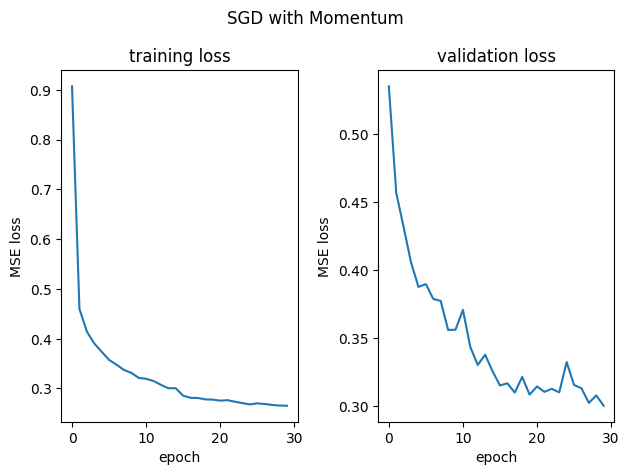

Optimizer: SGD with Momentum with learning rate: 0.001 and scheduler: MultiStepLR 

-------------------- Epoch 0 --------------------
Average Training Loss for epoch(over all batches) 0.9069776003603387
Validation loss for epoch: 0.5351)

-------------------- Epoch 1 --------------------
Average Training Loss for epoch(over all batches) 0.4598938719888704
Validation loss for epoch: 0.4568)

-------------------- Epoch 2 --------------------
Average Training Loss for epoch(over all batches) 0.41444123355028906
Validation loss for epoch: 0.4315)

-------------------- Epoch 3 --------------------
Average Training Loss for epoch(over all batches) 0.39046493794076736
Validation loss for epoch: 0.4056)

-------------------- Epoch 4 --------------------
Average Training Loss for epoch(over all batches) 0.3738936392540953
Validation loss for epoch: 0.3877)

-------------------- Epoch 5 --------------------
Average Training Loss for epoch(over all batches) 0.3545872125346049
Validation loss for 

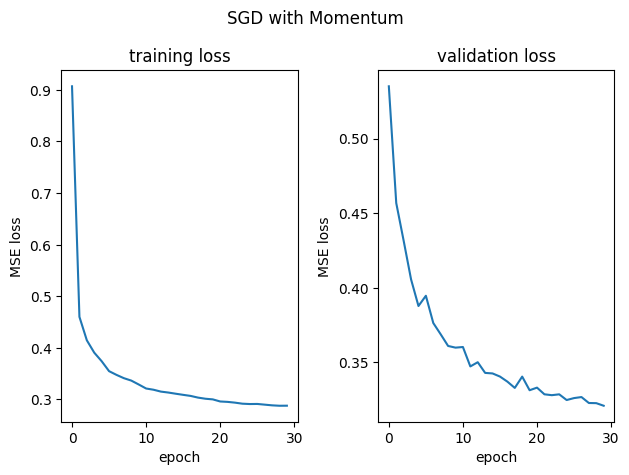

Optimizer: SGD with Momentum with learning rate: 0.001 and scheduler: CosineAnnealingLR 

-------------------- Epoch 0 --------------------
Average Training Loss for epoch(over all batches) 0.9069776003603387
Validation loss for epoch: 0.5351)

-------------------- Epoch 1 --------------------
Average Training Loss for epoch(over all batches) 0.45995770826672033
Validation loss for epoch: 0.4568)

-------------------- Epoch 2 --------------------
Average Training Loss for epoch(over all batches) 0.41453912227818396
Validation loss for epoch: 0.4316)

-------------------- Epoch 3 --------------------
Average Training Loss for epoch(over all batches) 0.39040762401985385
Validation loss for epoch: 0.4055)

-------------------- Epoch 4 --------------------
Average Training Loss for epoch(over all batches) 0.3739756870091753
Validation loss for epoch: 0.3885)

-------------------- Epoch 5 --------------------
Average Training Loss for epoch(over all batches) 0.35792693523772523
Validation l

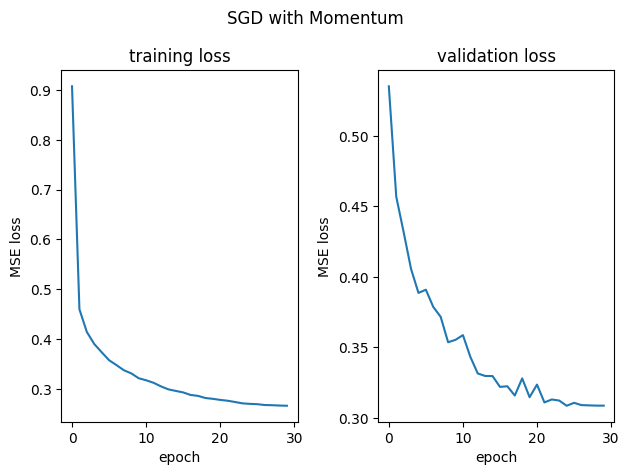

Optimizer: SGD with Momentum with learning rate: 0.001 and scheduler: CosineAnnealingWarmRestarts 

-------------------- Epoch 0 --------------------
Average Training Loss for epoch(over all batches) 0.9069776003603387
Validation loss for epoch: 0.5351)

-------------------- Epoch 1 --------------------
Average Training Loss for epoch(over all batches) 0.4601330039775477
Validation loss for epoch: 0.4569)

-------------------- Epoch 2 --------------------
Average Training Loss for epoch(over all batches) 0.41477413333754626
Validation loss for epoch: 0.4325)

-------------------- Epoch 3 --------------------
Average Training Loss for epoch(over all batches) 0.39056283001483016
Validation loss for epoch: 0.4057)

-------------------- Epoch 4 --------------------
Average Training Loss for epoch(over all batches) 0.37463550874551316
Validation loss for epoch: 0.3910)

-------------------- Epoch 5 --------------------
Average Training Loss for epoch(over all batches) 0.3593821946729337
Val

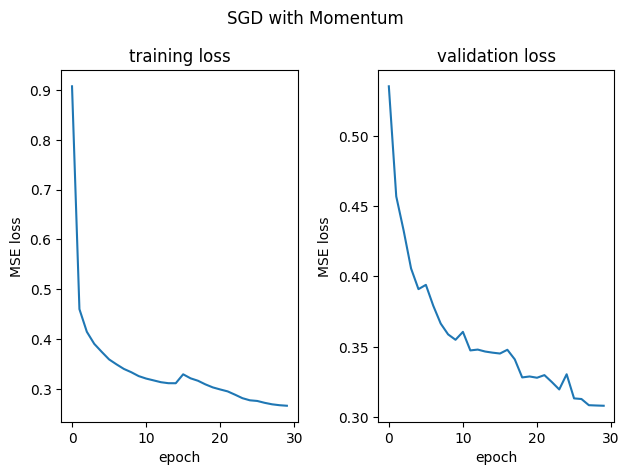

Optimizer: Nesterov SGD with Momentum with learning rate: 0.001 and scheduler: StepLR 

-------------------- Epoch 0 --------------------
Average Training Loss for epoch(over all batches) 0.8896571570199675
Validation loss for epoch: 0.5296)

-------------------- Epoch 1 --------------------
Average Training Loss for epoch(over all batches) 0.4565934306752365
Validation loss for epoch: 0.4492)

-------------------- Epoch 2 --------------------
Average Training Loss for epoch(over all batches) 0.410944823324021
Validation loss for epoch: 0.4242)

-------------------- Epoch 3 --------------------
Average Training Loss for epoch(over all batches) 0.3869735144771042
Validation loss for epoch: 0.4036)

-------------------- Epoch 4 --------------------
Average Training Loss for epoch(over all batches) 0.37070206597249594
Validation loss for epoch: 0.3860)

-------------------- Epoch 5 --------------------
Average Training Loss for epoch(over all batches) 0.3544828332630934
Validation loss fo

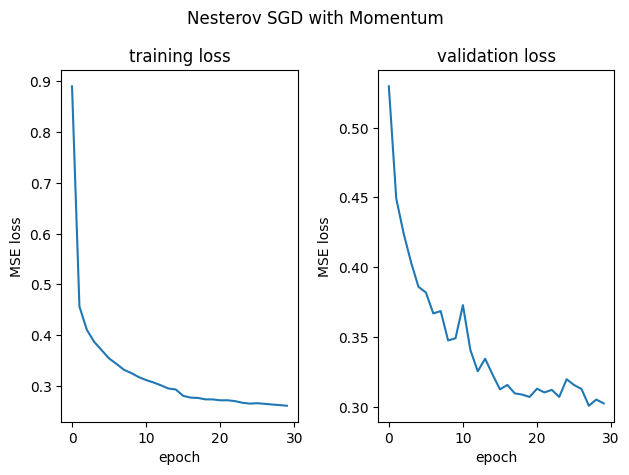

Optimizer: Nesterov SGD with Momentum with learning rate: 0.001 and scheduler: MultiStepLR 

-------------------- Epoch 0 --------------------
Average Training Loss for epoch(over all batches) 0.8896571570199675
Validation loss for epoch: 0.5296)

-------------------- Epoch 1 --------------------
Average Training Loss for epoch(over all batches) 0.4565934306752365
Validation loss for epoch: 0.4492)

-------------------- Epoch 2 --------------------
Average Training Loss for epoch(over all batches) 0.410944823324021
Validation loss for epoch: 0.4242)

-------------------- Epoch 3 --------------------
Average Training Loss for epoch(over all batches) 0.3869735144771042
Validation loss for epoch: 0.4036)

-------------------- Epoch 4 --------------------
Average Training Loss for epoch(over all batches) 0.37070206597249594
Validation loss for epoch: 0.3860)

-------------------- Epoch 5 --------------------
Average Training Loss for epoch(over all batches) 0.3521806403697856
Validation lo

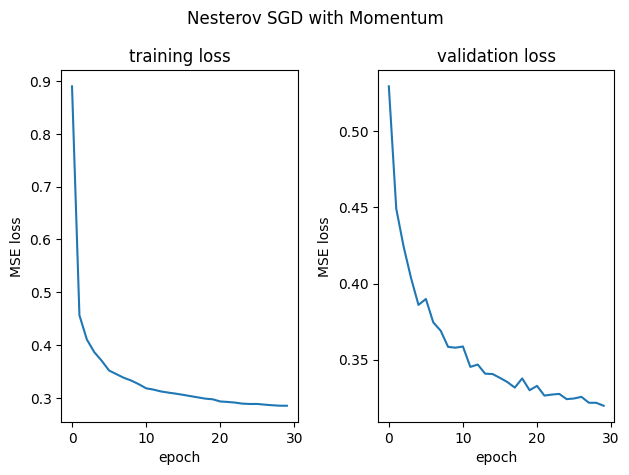

Optimizer: Nesterov SGD with Momentum with learning rate: 0.001 and scheduler: CosineAnnealingLR 

-------------------- Epoch 0 --------------------
Average Training Loss for epoch(over all batches) 0.8896571570199675
Validation loss for epoch: 0.5296)

-------------------- Epoch 1 --------------------
Average Training Loss for epoch(over all batches) 0.4566768654086421
Validation loss for epoch: 0.4494)

-------------------- Epoch 2 --------------------
Average Training Loss for epoch(over all batches) 0.41110847283781105
Validation loss for epoch: 0.4244)

-------------------- Epoch 3 --------------------
Average Training Loss for epoch(over all batches) 0.38715346437771764
Validation loss for epoch: 0.4039)

-------------------- Epoch 4 --------------------
Average Training Loss for epoch(over all batches) 0.3709702971102917
Validation loss for epoch: 0.3866)

-------------------- Epoch 5 --------------------
Average Training Loss for epoch(over all batches) 0.35501081794830025
Vali

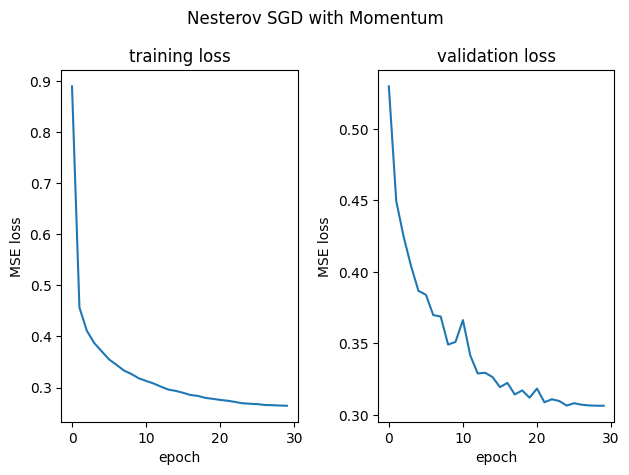

Optimizer: Nesterov SGD with Momentum with learning rate: 0.001 and scheduler: CosineAnnealingWarmRestarts 

-------------------- Epoch 0 --------------------
Average Training Loss for epoch(over all batches) 0.8896571570199675
Validation loss for epoch: 0.5296)

-------------------- Epoch 1 --------------------
Average Training Loss for epoch(over all batches) 0.4568717236737762
Validation loss for epoch: 0.4496)

-------------------- Epoch 2 --------------------
Average Training Loss for epoch(over all batches) 0.4114571157183531
Validation loss for epoch: 0.4251)

-------------------- Epoch 3 --------------------
Average Training Loss for epoch(over all batches) 0.38774158553409893
Validation loss for epoch: 0.4049)

-------------------- Epoch 4 --------------------
Average Training Loss for epoch(over all batches) 0.37177863034658726
Validation loss for epoch: 0.3889)

-------------------- Epoch 5 --------------------
Average Training Loss for epoch(over all batches) 0.356950016642

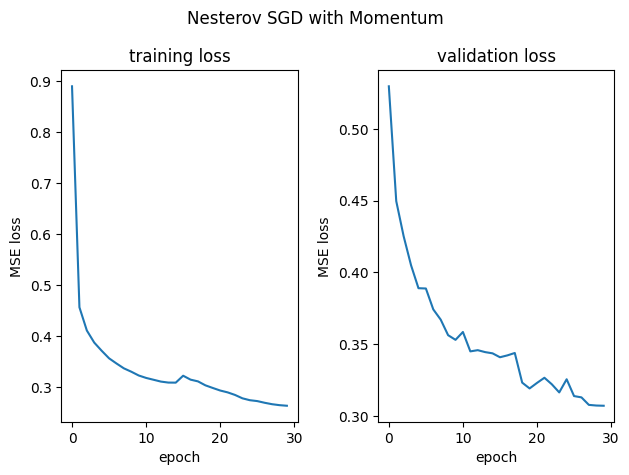

Optimizer: RMSProp with learning rate: 0.001 and scheduler: StepLR 

-------------------- Epoch 0 --------------------
Average Training Loss for epoch(over all batches) 0.5444327782410964
Validation loss for epoch: 0.4863)

-------------------- Epoch 1 --------------------
Average Training Loss for epoch(over all batches) 0.3910377509727151
Validation loss for epoch: 0.3955)

-------------------- Epoch 2 --------------------
Average Training Loss for epoch(over all batches) 0.3595739495239954
Validation loss for epoch: 0.3540)

-------------------- Epoch 3 --------------------
Average Training Loss for epoch(over all batches) 0.34632930698582026
Validation loss for epoch: 0.3426)

-------------------- Epoch 4 --------------------
Average Training Loss for epoch(over all batches) 0.32003870311366245
Validation loss for epoch: 0.3205)

-------------------- Epoch 5 --------------------
Average Training Loss for epoch(over all batches) 0.3102489999800393
Validation loss for epoch: 0.3182)


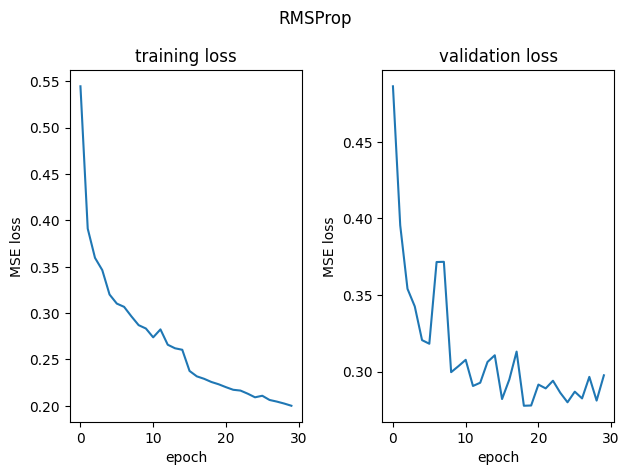

Optimizer: RMSProp with learning rate: 0.001 and scheduler: MultiStepLR 

-------------------- Epoch 0 --------------------
Average Training Loss for epoch(over all batches) 0.5444327782410964
Validation loss for epoch: 0.4863)

-------------------- Epoch 1 --------------------
Average Training Loss for epoch(over all batches) 0.3910377509727151
Validation loss for epoch: 0.3955)

-------------------- Epoch 2 --------------------
Average Training Loss for epoch(over all batches) 0.3595739495239954
Validation loss for epoch: 0.3540)

-------------------- Epoch 3 --------------------
Average Training Loss for epoch(over all batches) 0.34632930698582026
Validation loss for epoch: 0.3426)

-------------------- Epoch 4 --------------------
Average Training Loss for epoch(over all batches) 0.32003870311366245
Validation loss for epoch: 0.3205)

-------------------- Epoch 5 --------------------
Average Training Loss for epoch(over all batches) 0.28915614326509226
Validation loss for epoch: 0.

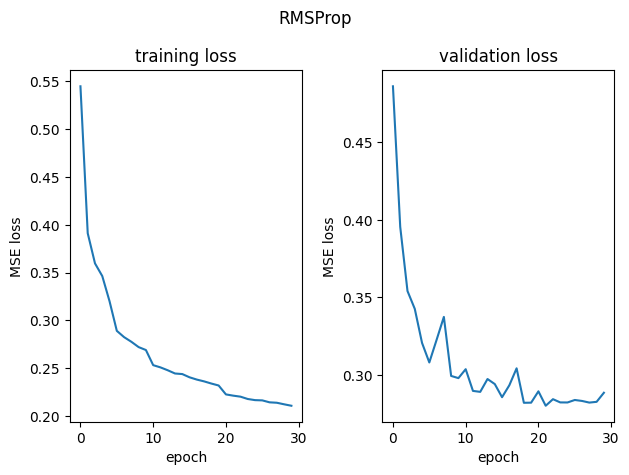

Optimizer: RMSProp with learning rate: 0.001 and scheduler: CosineAnnealingLR 

-------------------- Epoch 0 --------------------
Average Training Loss for epoch(over all batches) 0.5444327782410964
Validation loss for epoch: 0.4863)

-------------------- Epoch 1 --------------------
Average Training Loss for epoch(over all batches) 0.3911614262095067
Validation loss for epoch: 0.3979)

-------------------- Epoch 2 --------------------
Average Training Loss for epoch(over all batches) 0.35664557343332376
Validation loss for epoch: 0.3540)

-------------------- Epoch 3 --------------------
Average Training Loss for epoch(over all batches) 0.3454388686975019
Validation loss for epoch: 0.3426)

-------------------- Epoch 4 --------------------
Average Training Loss for epoch(over all batches) 0.31814956819984763
Validation loss for epoch: 0.3188)

-------------------- Epoch 5 --------------------
Average Training Loss for epoch(over all batches) 0.3081150802297402
Validation loss for epoc

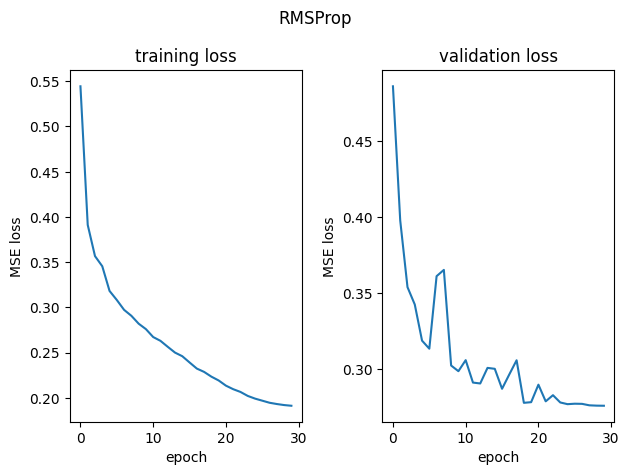

Optimizer: RMSProp with learning rate: 0.001 and scheduler: CosineAnnealingWarmRestarts 

-------------------- Epoch 0 --------------------
Average Training Loss for epoch(over all batches) 0.5444327782410964
Validation loss for epoch: 0.4863)

-------------------- Epoch 1 --------------------
Average Training Loss for epoch(over all batches) 0.3907350030587574
Validation loss for epoch: 0.3969)

-------------------- Epoch 2 --------------------
Average Training Loss for epoch(over all batches) 0.3565578911437002
Validation loss for epoch: 0.3530)

-------------------- Epoch 3 --------------------
Average Training Loss for epoch(over all batches) 0.33768437135206386
Validation loss for epoch: 0.3403)

-------------------- Epoch 4 --------------------
Average Training Loss for epoch(over all batches) 0.31483230957415254
Validation loss for epoch: 0.3187)

-------------------- Epoch 5 --------------------
Average Training Loss for epoch(over all batches) 0.3076518674471737
Validation los

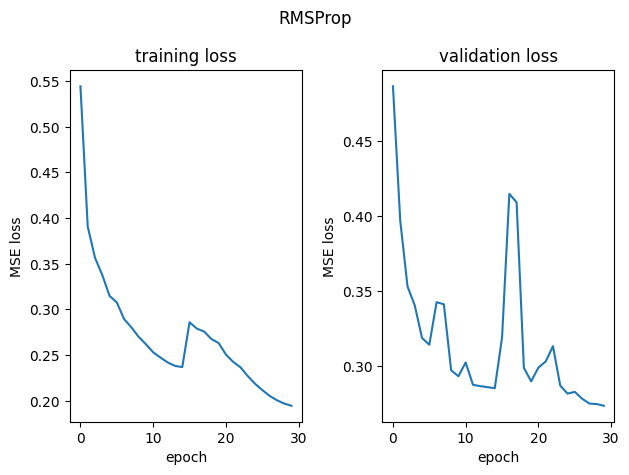

Optimizer: Adam with learning rate: 0.001 and scheduler: StepLR 

-------------------- Epoch 0 --------------------
Average Training Loss for epoch(over all batches) 0.6257828838496873
Validation loss for epoch: 0.4207)

-------------------- Epoch 1 --------------------
Average Training Loss for epoch(over all batches) 0.37377937443026926
Validation loss for epoch: 0.3668)

-------------------- Epoch 2 --------------------
Average Training Loss for epoch(over all batches) 0.3506221688162964
Validation loss for epoch: 0.3807)

-------------------- Epoch 3 --------------------
Average Training Loss for epoch(over all batches) 0.3284354449900906
Validation loss for epoch: 0.3335)

-------------------- Epoch 4 --------------------
Average Training Loss for epoch(over all batches) 0.32858197094328634
Validation loss for epoch: 0.3248)

-------------------- Epoch 5 --------------------
Average Training Loss for epoch(over all batches) 0.3053194677572599
Validation loss for epoch: 0.3159)

--

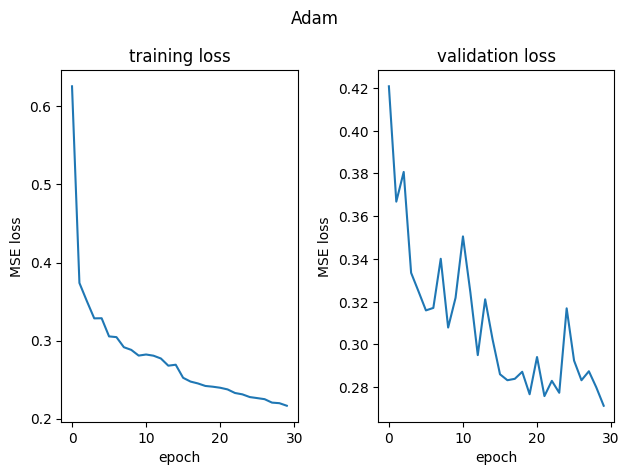

Optimizer: Adam with learning rate: 0.001 and scheduler: MultiStepLR 

-------------------- Epoch 0 --------------------
Average Training Loss for epoch(over all batches) 0.6257828838496873
Validation loss for epoch: 0.4207)

-------------------- Epoch 1 --------------------
Average Training Loss for epoch(over all batches) 0.37377937443026926
Validation loss for epoch: 0.3668)

-------------------- Epoch 2 --------------------
Average Training Loss for epoch(over all batches) 0.3506221688162964
Validation loss for epoch: 0.3807)

-------------------- Epoch 3 --------------------
Average Training Loss for epoch(over all batches) 0.3284354449900906
Validation loss for epoch: 0.3335)

-------------------- Epoch 4 --------------------
Average Training Loss for epoch(over all batches) 0.32858197094328634
Validation loss for epoch: 0.3248)

-------------------- Epoch 5 --------------------
Average Training Loss for epoch(over all batches) 0.29025045078478556
Validation loss for epoch: 0.321

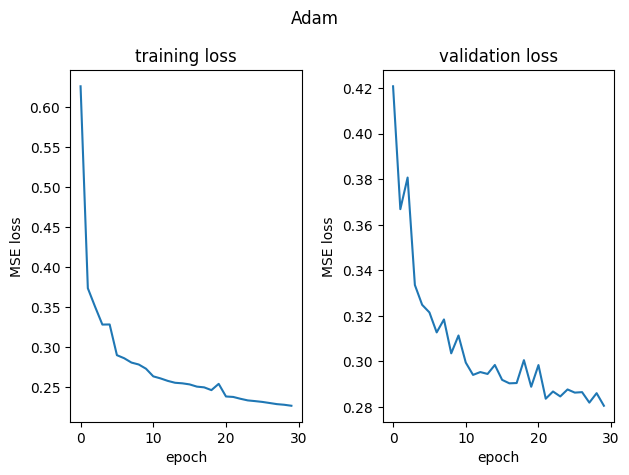

Optimizer: Adam with learning rate: 0.001 and scheduler: CosineAnnealingLR 

-------------------- Epoch 0 --------------------
Average Training Loss for epoch(over all batches) 0.6257828838496873
Validation loss for epoch: 0.4207)

-------------------- Epoch 1 --------------------
Average Training Loss for epoch(over all batches) 0.37391187634681705
Validation loss for epoch: 0.3668)

-------------------- Epoch 2 --------------------
Average Training Loss for epoch(over all batches) 0.35234368482060663
Validation loss for epoch: 0.3855)

-------------------- Epoch 3 --------------------
Average Training Loss for epoch(over all batches) 0.3273453095482778
Validation loss for epoch: 0.3337)

-------------------- Epoch 4 --------------------
Average Training Loss for epoch(over all batches) 0.31677585879785825
Validation loss for epoch: 0.3227)

-------------------- Epoch 5 --------------------
Average Training Loss for epoch(over all batches) 0.29930666748401336
Validation loss for epoch

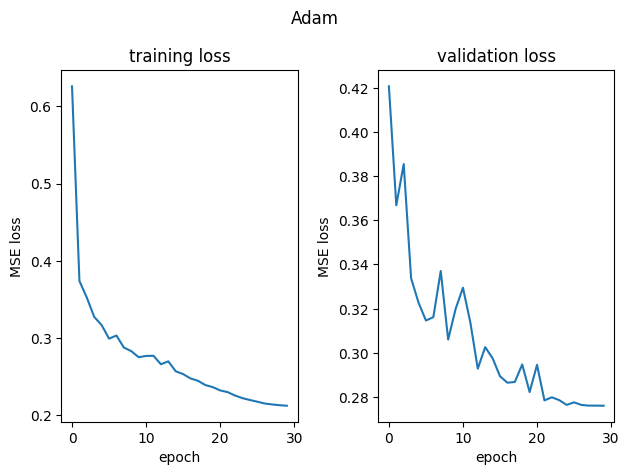

Optimizer: Adam with learning rate: 0.001 and scheduler: CosineAnnealingWarmRestarts 

-------------------- Epoch 0 --------------------
Average Training Loss for epoch(over all batches) 0.6257828838496873
Validation loss for epoch: 0.4207)

-------------------- Epoch 1 --------------------
Average Training Loss for epoch(over all batches) 0.37372719526159026
Validation loss for epoch: 0.3682)

-------------------- Epoch 2 --------------------
Average Training Loss for epoch(over all batches) 0.3526663042571956
Validation loss for epoch: 0.3726)

-------------------- Epoch 3 --------------------
Average Training Loss for epoch(over all batches) 0.3336026327008695
Validation loss for epoch: 0.3322)

-------------------- Epoch 4 --------------------
Average Training Loss for epoch(over all batches) 0.31351749566012777
Validation loss for epoch: 0.3221)

-------------------- Epoch 5 --------------------
Average Training Loss for epoch(over all batches) 0.29719168912058913
Validation loss 

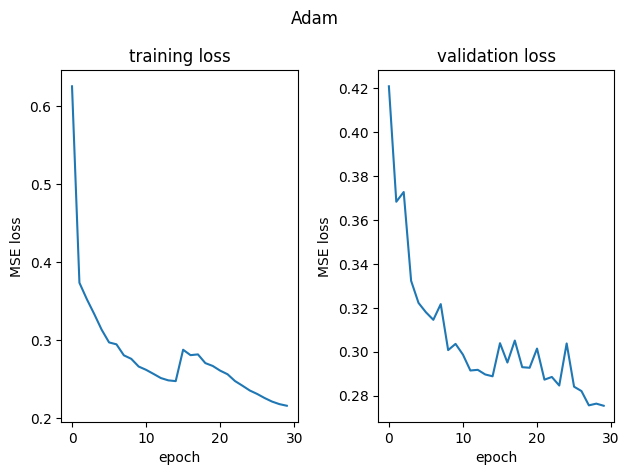

Optimizer: SGD with learning rate: 0.005 and scheduler: StepLR 

-------------------- Epoch 0 --------------------
Average Training Loss for epoch(over all batches) 1.0126357121409568
Validation loss for epoch: 0.6028)

-------------------- Epoch 1 --------------------
Average Training Loss for epoch(over all batches) 0.5236191043745627
Validation loss for epoch: 0.4973)

-------------------- Epoch 2 --------------------
Average Training Loss for epoch(over all batches) 0.4510471796105921
Validation loss for epoch: 0.4618)

-------------------- Epoch 3 --------------------
Average Training Loss for epoch(over all batches) 0.421905345192789
Validation loss for epoch: 0.4400)

-------------------- Epoch 4 --------------------
Average Training Loss for epoch(over all batches) 0.4040391734776507
Validation loss for epoch: 0.4198)

-------------------- Epoch 5 --------------------
Average Training Loss for epoch(over all batches) 0.3901514560149043
Validation loss for epoch: 0.4117)

------

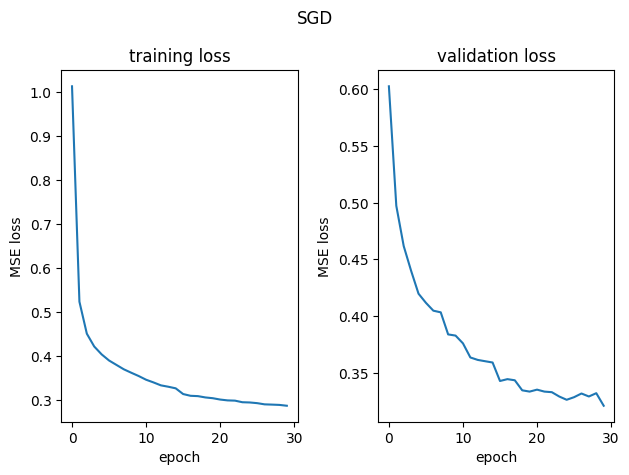

Optimizer: SGD with learning rate: 0.005 and scheduler: MultiStepLR 

-------------------- Epoch 0 --------------------
Average Training Loss for epoch(over all batches) 1.0126357121409568
Validation loss for epoch: 0.6028)

-------------------- Epoch 1 --------------------
Average Training Loss for epoch(over all batches) 0.5236191043745627
Validation loss for epoch: 0.4973)

-------------------- Epoch 2 --------------------
Average Training Loss for epoch(over all batches) 0.4510471796105921
Validation loss for epoch: 0.4618)

-------------------- Epoch 3 --------------------
Average Training Loss for epoch(over all batches) 0.421905345192789
Validation loss for epoch: 0.4400)

-------------------- Epoch 4 --------------------
Average Training Loss for epoch(over all batches) 0.4040391734776507
Validation loss for epoch: 0.4198)

-------------------- Epoch 5 --------------------
Average Training Loss for epoch(over all batches) 0.3884599982900957
Validation loss for epoch: 0.4162)

-

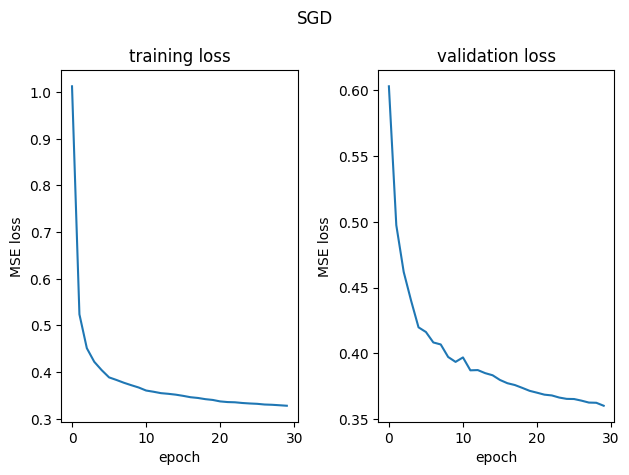

Optimizer: SGD with learning rate: 0.005 and scheduler: CosineAnnealingLR 

-------------------- Epoch 0 --------------------
Average Training Loss for epoch(over all batches) 1.0126357121409568
Validation loss for epoch: 0.6028)

-------------------- Epoch 1 --------------------
Average Training Loss for epoch(over all batches) 0.5237368147127923
Validation loss for epoch: 0.4975)

-------------------- Epoch 2 --------------------
Average Training Loss for epoch(over all batches) 0.4512713168113105
Validation loss for epoch: 0.4620)

-------------------- Epoch 3 --------------------
Average Training Loss for epoch(over all batches) 0.422259832312048
Validation loss for epoch: 0.4402)

-------------------- Epoch 4 --------------------
Average Training Loss for epoch(over all batches) 0.4045418334745728
Validation loss for epoch: 0.4207)

-------------------- Epoch 5 --------------------
Average Training Loss for epoch(over all batches) 0.3908508431364213
Validation loss for epoch: 0.41

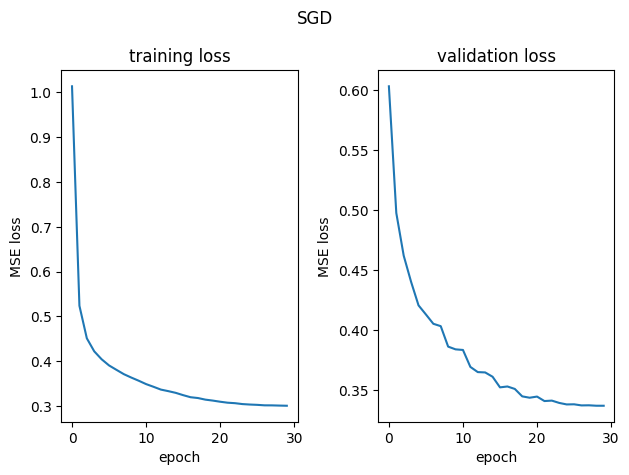

Optimizer: SGD with learning rate: 0.005 and scheduler: CosineAnnealingWarmRestarts 

-------------------- Epoch 0 --------------------
Average Training Loss for epoch(over all batches) 1.0126357121409568
Validation loss for epoch: 0.6028)

-------------------- Epoch 1 --------------------
Average Training Loss for epoch(over all batches) 0.5240971610873146
Validation loss for epoch: 0.4979)

-------------------- Epoch 2 --------------------
Average Training Loss for epoch(over all batches) 0.45204144281096165
Validation loss for epoch: 0.4627)

-------------------- Epoch 3 --------------------
Average Training Loss for epoch(over all batches) 0.4233104442534721
Validation loss for epoch: 0.4414)

-------------------- Epoch 4 --------------------
Average Training Loss for epoch(over all batches) 0.4061216132599959
Validation loss for epoch: 0.4236)

-------------------- Epoch 5 --------------------
Average Training Loss for epoch(over all batches) 0.3930043186168228
Validation loss for

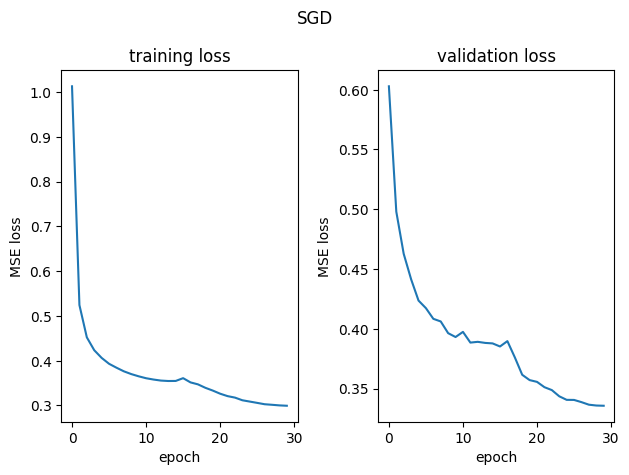

Optimizer: SGD with Momentum with learning rate: 0.005 and scheduler: StepLR 

-------------------- Epoch 0 --------------------
Average Training Loss for epoch(over all batches) 0.6559567176860518
Validation loss for epoch: 0.4610)

-------------------- Epoch 1 --------------------
Average Training Loss for epoch(over all batches) 0.40991471175401084
Validation loss for epoch: 0.3993)

-------------------- Epoch 2 --------------------
Average Training Loss for epoch(over all batches) 0.37392543328810585
Validation loss for epoch: 0.4586)

-------------------- Epoch 3 --------------------
Average Training Loss for epoch(over all batches) 0.3552672243553453
Validation loss for epoch: 0.3595)

-------------------- Epoch 4 --------------------
Average Training Loss for epoch(over all batches) 0.33937094329271167
Validation loss for epoch: 0.3611)

-------------------- Epoch 5 --------------------
Average Training Loss for epoch(over all batches) 0.32161514531919916
Validation loss for epo

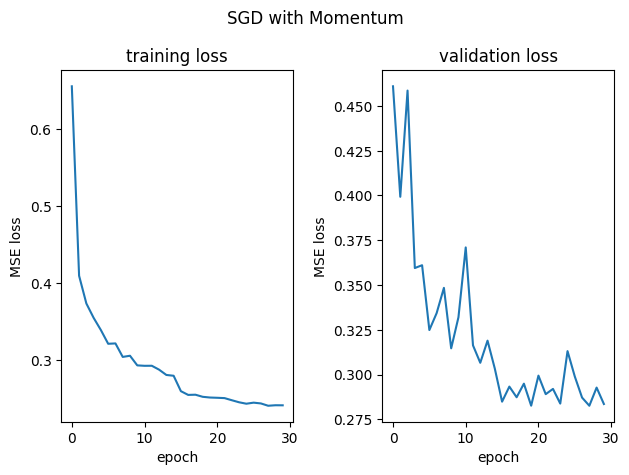

Optimizer: SGD with Momentum with learning rate: 0.005 and scheduler: MultiStepLR 

-------------------- Epoch 0 --------------------
Average Training Loss for epoch(over all batches) 0.6559567176860518
Validation loss for epoch: 0.4610)

-------------------- Epoch 1 --------------------
Average Training Loss for epoch(over all batches) 0.40991471175401084
Validation loss for epoch: 0.3993)

-------------------- Epoch 2 --------------------
Average Training Loss for epoch(over all batches) 0.37392543328810585
Validation loss for epoch: 0.4586)

-------------------- Epoch 3 --------------------
Average Training Loss for epoch(over all batches) 0.3552672243553453
Validation loss for epoch: 0.3595)

-------------------- Epoch 4 --------------------
Average Training Loss for epoch(over all batches) 0.33937094329271167
Validation loss for epoch: 0.3611)

-------------------- Epoch 5 --------------------
Average Training Loss for epoch(over all batches) 0.30610746934812155
Validation loss fo

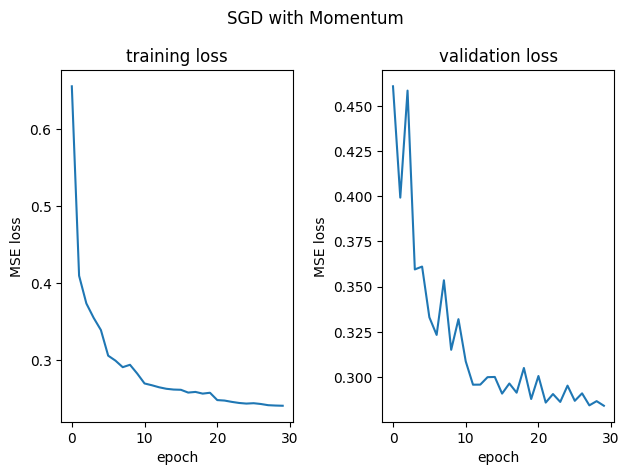

Optimizer: SGD with Momentum with learning rate: 0.005 and scheduler: CosineAnnealingLR 

-------------------- Epoch 0 --------------------
Average Training Loss for epoch(over all batches) 0.6559567176860518
Validation loss for epoch: 0.4610)

-------------------- Epoch 1 --------------------
Average Training Loss for epoch(over all batches) 0.40956071360382884
Validation loss for epoch: 0.3996)

-------------------- Epoch 2 --------------------
Average Training Loss for epoch(over all batches) 0.37382779634697777
Validation loss for epoch: 0.4475)

-------------------- Epoch 3 --------------------
Average Training Loss for epoch(over all batches) 0.35470267421508256
Validation loss for epoch: 0.3612)

-------------------- Epoch 4 --------------------
Average Training Loss for epoch(over all batches) 0.3384793126807276
Validation loss for epoch: 0.3564)

-------------------- Epoch 5 --------------------
Average Training Loss for epoch(over all batches) 0.32116106615723233
Validation l

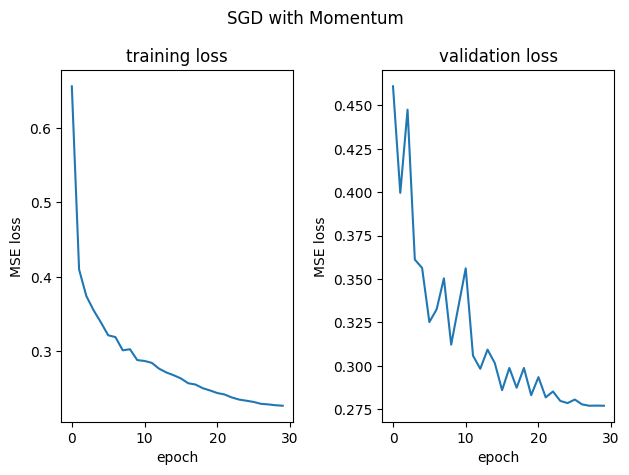

Optimizer: SGD with Momentum with learning rate: 0.005 and scheduler: CosineAnnealingWarmRestarts 

-------------------- Epoch 0 --------------------
Average Training Loss for epoch(over all batches) 0.6559567176860518
Validation loss for epoch: 0.4610)

-------------------- Epoch 1 --------------------
Average Training Loss for epoch(over all batches) 0.409474693288186
Validation loss for epoch: 0.3996)

-------------------- Epoch 2 --------------------
Average Training Loss for epoch(over all batches) 0.3729736019024807
Validation loss for epoch: 0.4491)

-------------------- Epoch 3 --------------------
Average Training Loss for epoch(over all batches) 0.3527167769462134
Validation loss for epoch: 0.3588)

-------------------- Epoch 4 --------------------
Average Training Loss for epoch(over all batches) 0.33610064160507336
Validation loss for epoch: 0.3498)

-------------------- Epoch 5 --------------------
Average Training Loss for epoch(over all batches) 0.3169296131329199
Valida

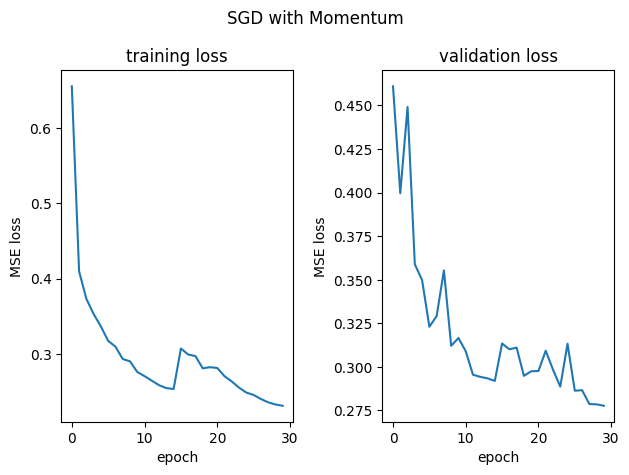

Optimizer: Nesterov SGD with Momentum with learning rate: 0.005 and scheduler: StepLR 

-------------------- Epoch 0 --------------------
Average Training Loss for epoch(over all batches) 0.6124876760341952
Validation loss for epoch: 0.4335)

-------------------- Epoch 1 --------------------
Average Training Loss for epoch(over all batches) 0.3917364953168198
Validation loss for epoch: 0.4099)

-------------------- Epoch 2 --------------------
Average Training Loss for epoch(over all batches) 0.3601360725881779
Validation loss for epoch: 0.3966)

-------------------- Epoch 3 --------------------
Average Training Loss for epoch(over all batches) 0.34238785406393285
Validation loss for epoch: 0.3489)

-------------------- Epoch 4 --------------------
Average Training Loss for epoch(over all batches) 0.3262280198226197
Validation loss for epoch: 0.3536)

-------------------- Epoch 5 --------------------
Average Training Loss for epoch(over all batches) 0.3105956728908077
Validation loss f

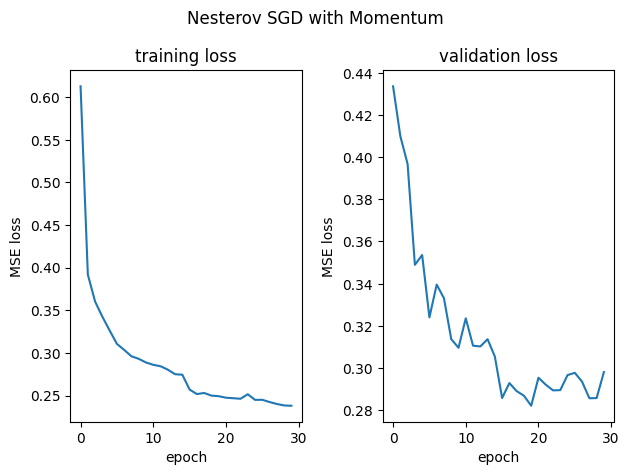

Optimizer: Nesterov SGD with Momentum with learning rate: 0.005 and scheduler: MultiStepLR 

-------------------- Epoch 0 --------------------
Average Training Loss for epoch(over all batches) 0.6124876760341952
Validation loss for epoch: 0.4335)

-------------------- Epoch 1 --------------------
Average Training Loss for epoch(over all batches) 0.3917364953168198
Validation loss for epoch: 0.4099)

-------------------- Epoch 2 --------------------
Average Training Loss for epoch(over all batches) 0.3601360725881779
Validation loss for epoch: 0.3966)

-------------------- Epoch 3 --------------------
Average Training Loss for epoch(over all batches) 0.34238785406393285
Validation loss for epoch: 0.3489)

-------------------- Epoch 4 --------------------
Average Training Loss for epoch(over all batches) 0.3262280198226197
Validation loss for epoch: 0.3536)

-------------------- Epoch 5 --------------------
Average Training Loss for epoch(over all batches) 0.29721551421469294
Validation 

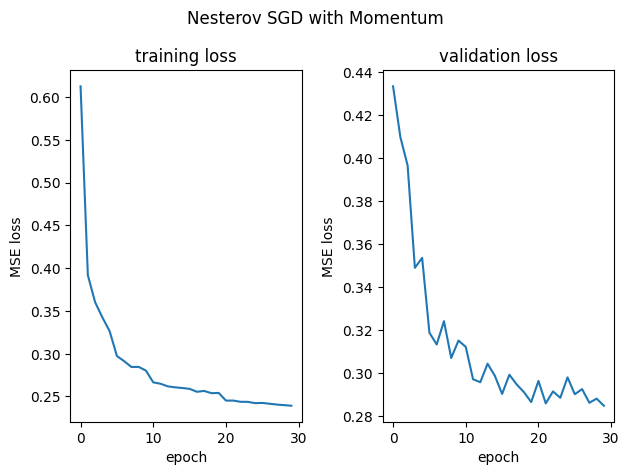

Optimizer: Nesterov SGD with Momentum with learning rate: 0.005 and scheduler: CosineAnnealingLR 

-------------------- Epoch 0 --------------------
Average Training Loss for epoch(over all batches) 0.6124876760341952
Validation loss for epoch: 0.4335)

-------------------- Epoch 1 --------------------
Average Training Loss for epoch(over all batches) 0.39174989460909787
Validation loss for epoch: 0.4119)

-------------------- Epoch 2 --------------------
Average Training Loss for epoch(over all batches) 0.35982360121324264
Validation loss for epoch: 0.3948)

-------------------- Epoch 3 --------------------
Average Training Loss for epoch(over all batches) 0.3423118029053496
Validation loss for epoch: 0.3498)

-------------------- Epoch 4 --------------------
Average Training Loss for epoch(over all batches) 0.32483075463534455
Validation loss for epoch: 0.3510)

-------------------- Epoch 5 --------------------
Average Training Loss for epoch(over all batches) 0.30913285904489785
Val

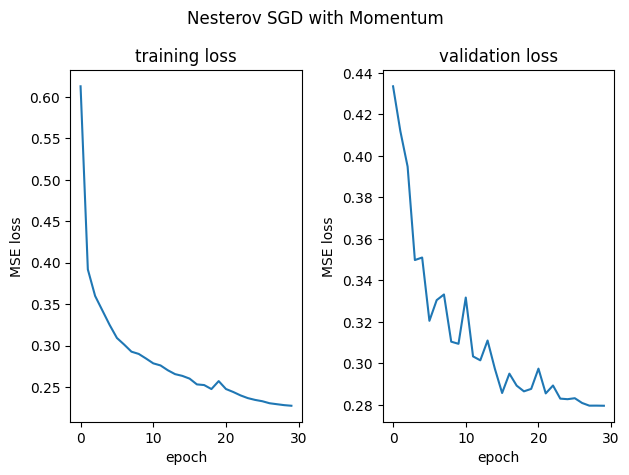

Optimizer: Nesterov SGD with Momentum with learning rate: 0.005 and scheduler: CosineAnnealingWarmRestarts 

-------------------- Epoch 0 --------------------
Average Training Loss for epoch(over all batches) 0.6124876760341952
Validation loss for epoch: 0.4335)

-------------------- Epoch 1 --------------------
Average Training Loss for epoch(over all batches) 0.3914237663281702
Validation loss for epoch: 0.4093)

-------------------- Epoch 2 --------------------
Average Training Loss for epoch(over all batches) 0.3591288565534406
Validation loss for epoch: 0.3953)

-------------------- Epoch 3 --------------------
Average Training Loss for epoch(over all batches) 0.341161205952542
Validation loss for epoch: 0.3495)

-------------------- Epoch 4 --------------------
Average Training Loss for epoch(over all batches) 0.32304768381327126
Validation loss for epoch: 0.3540)

-------------------- Epoch 5 --------------------
Average Training Loss for epoch(over all batches) 0.30575433808617

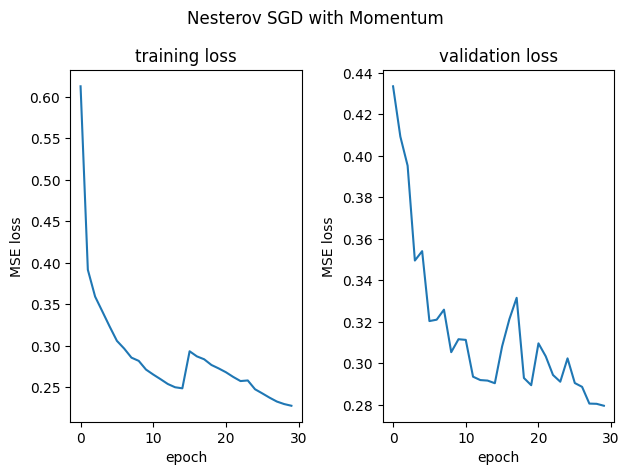

Optimizer: RMSProp with learning rate: 0.005 and scheduler: StepLR 

-------------------- Epoch 0 --------------------
Average Training Loss for epoch(over all batches) 8.148295600577134
Validation loss for epoch: 0.5168)

-------------------- Epoch 1 --------------------
Average Training Loss for epoch(over all batches) 0.4501217918190281
Validation loss for epoch: 0.4176)

-------------------- Epoch 2 --------------------
Average Training Loss for epoch(over all batches) 0.4223525192159995
Validation loss for epoch: 0.3740)

-------------------- Epoch 3 --------------------
Average Training Loss for epoch(over all batches) 0.37245811991789174
Validation loss for epoch: 0.3607)

-------------------- Epoch 4 --------------------
Average Training Loss for epoch(over all batches) 0.3417395152547191
Validation loss for epoch: 0.3228)

-------------------- Epoch 5 --------------------
Average Training Loss for epoch(over all batches) 0.35218065415006294
Validation loss for epoch: 0.3275)



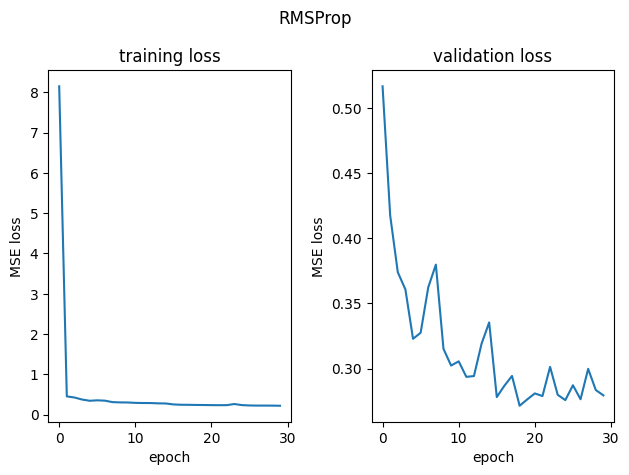

Optimizer: RMSProp with learning rate: 0.005 and scheduler: MultiStepLR 

-------------------- Epoch 0 --------------------
Average Training Loss for epoch(over all batches) 8.148295600577134
Validation loss for epoch: 0.5168)

-------------------- Epoch 1 --------------------
Average Training Loss for epoch(over all batches) 0.4501217918190281
Validation loss for epoch: 0.4176)

-------------------- Epoch 2 --------------------
Average Training Loss for epoch(over all batches) 0.4223525192159995
Validation loss for epoch: 0.3740)

-------------------- Epoch 3 --------------------
Average Training Loss for epoch(over all batches) 0.37245811991789174
Validation loss for epoch: 0.3607)

-------------------- Epoch 4 --------------------
Average Training Loss for epoch(over all batches) 0.3417395152547191
Validation loss for epoch: 0.3228)

-------------------- Epoch 5 --------------------
Average Training Loss for epoch(over all batches) 0.31095570759369734
Validation loss for epoch: 0.31

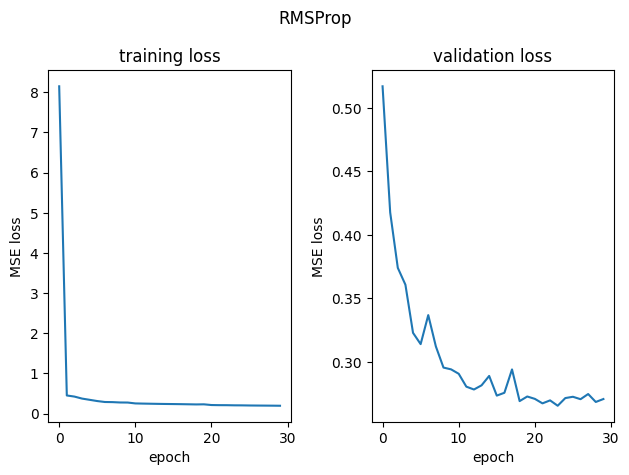

Optimizer: RMSProp with learning rate: 0.005 and scheduler: CosineAnnealingLR 

-------------------- Epoch 0 --------------------
Average Training Loss for epoch(over all batches) 8.148295600577134
Validation loss for epoch: 0.5168)

-------------------- Epoch 1 --------------------
Average Training Loss for epoch(over all batches) 0.45056515447465717
Validation loss for epoch: 0.4260)

-------------------- Epoch 2 --------------------
Average Training Loss for epoch(over all batches) 0.41858935891856663
Validation loss for epoch: 0.3694)

-------------------- Epoch 3 --------------------
Average Training Loss for epoch(over all batches) 0.38519997392014593
Validation loss for epoch: 0.3552)

-------------------- Epoch 4 --------------------
Average Training Loss for epoch(over all batches) 0.34350118547084585
Validation loss for epoch: 0.3263)

-------------------- Epoch 5 --------------------
Average Training Loss for epoch(over all batches) 0.3312945752610675
Validation loss for epo

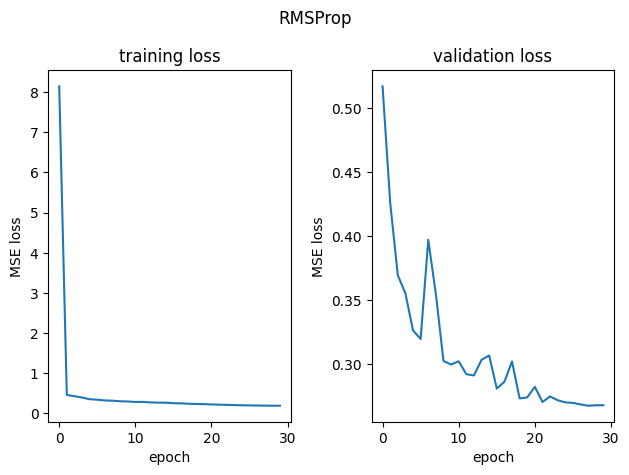

Optimizer: RMSProp with learning rate: 0.005 and scheduler: CosineAnnealingWarmRestarts 

-------------------- Epoch 0 --------------------
Average Training Loss for epoch(over all batches) 8.148295600577134
Validation loss for epoch: 0.5168)

-------------------- Epoch 1 --------------------
Average Training Loss for epoch(over all batches) 0.4520322646517142
Validation loss for epoch: 0.4266)

-------------------- Epoch 2 --------------------
Average Training Loss for epoch(over all batches) 0.4048576864817765
Validation loss for epoch: 0.3741)

-------------------- Epoch 3 --------------------
Average Training Loss for epoch(over all batches) 0.3785081636325448
Validation loss for epoch: 0.3541)

-------------------- Epoch 4 --------------------
Average Training Loss for epoch(over all batches) 0.3320156323632835
Validation loss for epoch: 0.3230)

-------------------- Epoch 5 --------------------
Average Training Loss for epoch(over all batches) 0.39268490691891816
Validation loss 

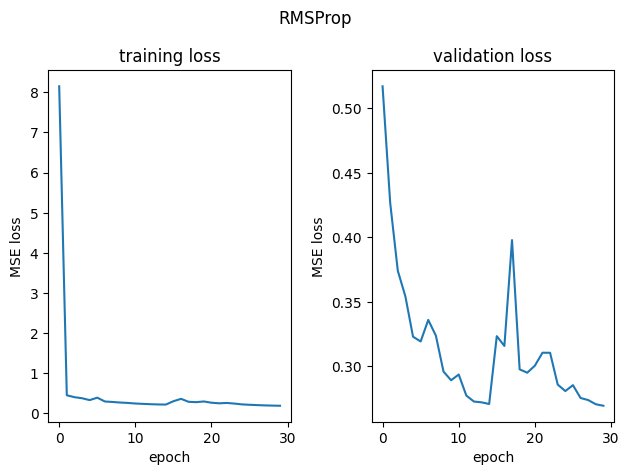

Optimizer: Adam with learning rate: 0.005 and scheduler: StepLR 

-------------------- Epoch 0 --------------------
Average Training Loss for epoch(over all batches) 0.5111860023333435
Validation loss for epoch: 0.4108)

-------------------- Epoch 1 --------------------
Average Training Loss for epoch(over all batches) 0.38656411827665516
Validation loss for epoch: 0.3539)

-------------------- Epoch 2 --------------------
Average Training Loss for epoch(over all batches) 0.3525980379333538
Validation loss for epoch: 0.4646)

-------------------- Epoch 3 --------------------
Average Training Loss for epoch(over all batches) 0.33814947435681797
Validation loss for epoch: 0.3397)

-------------------- Epoch 4 --------------------
Average Training Loss for epoch(over all batches) 0.32743287450774056
Validation loss for epoch: 0.3859)

-------------------- Epoch 5 --------------------
Average Training Loss for epoch(over all batches) 0.3858708210487281
Validation loss for epoch: 0.3112)

-

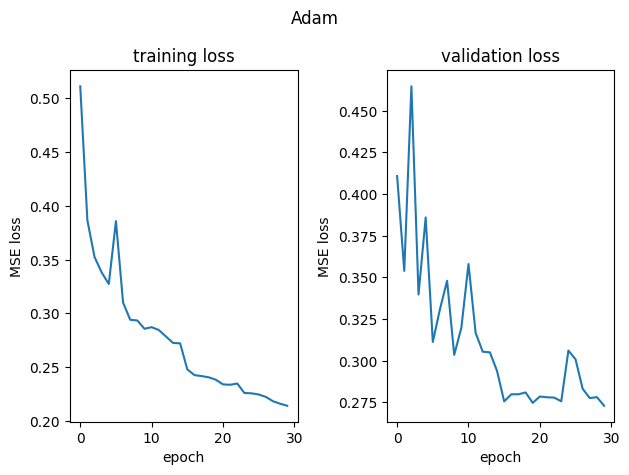

Optimizer: Adam with learning rate: 0.005 and scheduler: MultiStepLR 

-------------------- Epoch 0 --------------------
Average Training Loss for epoch(over all batches) 0.5111860023333435
Validation loss for epoch: 0.4108)

-------------------- Epoch 1 --------------------
Average Training Loss for epoch(over all batches) 0.38656411827665516
Validation loss for epoch: 0.3539)

-------------------- Epoch 2 --------------------
Average Training Loss for epoch(over all batches) 0.3525980379333538
Validation loss for epoch: 0.4646)

-------------------- Epoch 3 --------------------
Average Training Loss for epoch(over all batches) 0.33814947435681797
Validation loss for epoch: 0.3397)

-------------------- Epoch 4 --------------------
Average Training Loss for epoch(over all batches) 0.32743287450774056
Validation loss for epoch: 0.3859)

-------------------- Epoch 5 --------------------
Average Training Loss for epoch(over all batches) 0.29852301912563567
Validation loss for epoch: 0.30

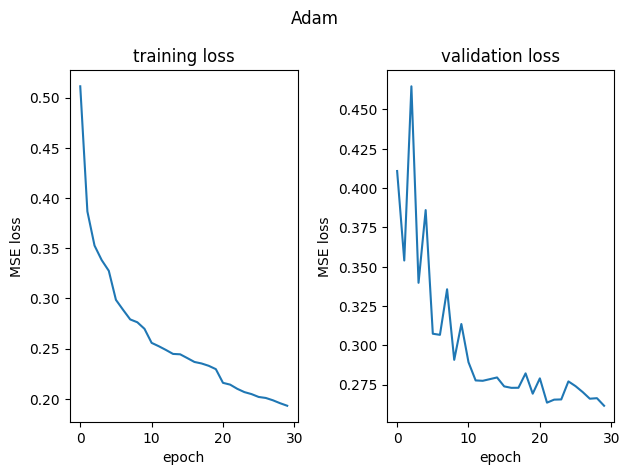

Optimizer: Adam with learning rate: 0.005 and scheduler: CosineAnnealingLR 

-------------------- Epoch 0 --------------------
Average Training Loss for epoch(over all batches) 0.5111860023333435
Validation loss for epoch: 0.4108)

-------------------- Epoch 1 --------------------
Average Training Loss for epoch(over all batches) 0.3892656873120407
Validation loss for epoch: 0.3535)

-------------------- Epoch 2 --------------------
Average Training Loss for epoch(over all batches) 0.3496812990808909
Validation loss for epoch: 0.4710)

-------------------- Epoch 3 --------------------
Average Training Loss for epoch(over all batches) 0.37631720836908944
Validation loss for epoch: 0.3330)

-------------------- Epoch 4 --------------------
Average Training Loss for epoch(over all batches) 0.3261780146080836
Validation loss for epoch: 0.3491)

-------------------- Epoch 5 --------------------
Average Training Loss for epoch(over all batches) 0.3068259722363632
Validation loss for epoch: 0

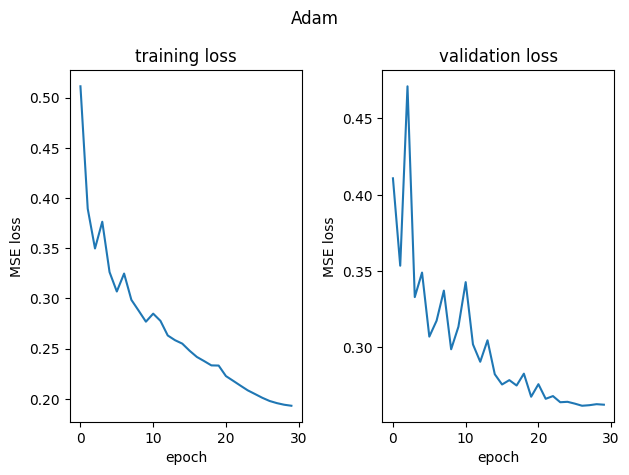

Optimizer: Adam with learning rate: 0.005 and scheduler: CosineAnnealingWarmRestarts 

-------------------- Epoch 0 --------------------
Average Training Loss for epoch(over all batches) 0.5111860023333435
Validation loss for epoch: 0.4108)

-------------------- Epoch 1 --------------------
Average Training Loss for epoch(over all batches) 0.3887835264997145
Validation loss for epoch: 0.3526)

-------------------- Epoch 2 --------------------
Average Training Loss for epoch(over all batches) 0.34781976804071296
Validation loss for epoch: 0.4624)

-------------------- Epoch 3 --------------------
Average Training Loss for epoch(over all batches) 0.4468348181880681
Validation loss for epoch: 0.3339)

-------------------- Epoch 4 --------------------
Average Training Loss for epoch(over all batches) 0.32091126604154047
Validation loss for epoch: 0.3312)

-------------------- Epoch 5 --------------------
Average Training Loss for epoch(over all batches) 0.3044404713684215
Validation loss f

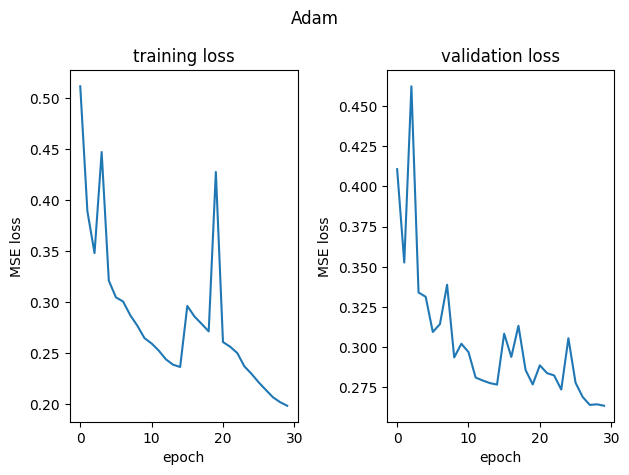

Optimizer: SGD with learning rate: 0.01 and scheduler: StepLR 

-------------------- Epoch 0 --------------------
Average Training Loss for epoch(over all batches) 0.780925343258191
Validation loss for epoch: 0.5033)

-------------------- Epoch 1 --------------------
Average Training Loss for epoch(over all batches) 0.4474761119128856
Validation loss for epoch: 0.4657)

-------------------- Epoch 2 --------------------
Average Training Loss for epoch(over all batches) 0.40994071833525614
Validation loss for epoch: 0.4275)

-------------------- Epoch 3 --------------------
Average Training Loss for epoch(over all batches) 0.39080679785888806
Validation loss for epoch: 0.4188)

-------------------- Epoch 4 --------------------
Average Training Loss for epoch(over all batches) 0.37547720241797183
Validation loss for epoch: 0.3860)

-------------------- Epoch 5 --------------------
Average Training Loss for epoch(over all batches) 0.3644774908579029
Validation loss for epoch: 0.3764)

----

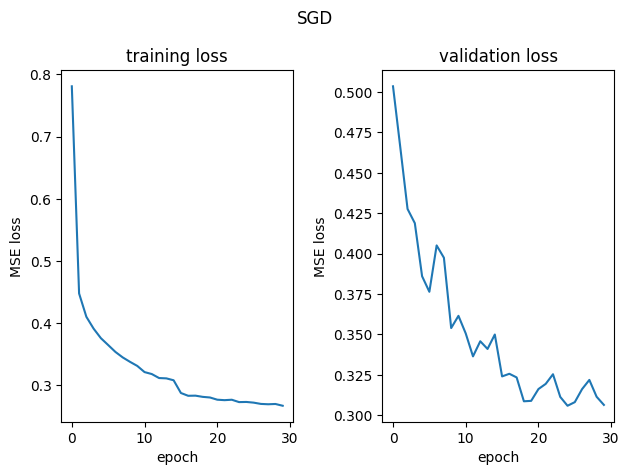

Optimizer: SGD with learning rate: 0.01 and scheduler: MultiStepLR 

-------------------- Epoch 0 --------------------
Average Training Loss for epoch(over all batches) 0.780925343258191
Validation loss for epoch: 0.5033)

-------------------- Epoch 1 --------------------
Average Training Loss for epoch(over all batches) 0.4474761119128856
Validation loss for epoch: 0.4657)

-------------------- Epoch 2 --------------------
Average Training Loss for epoch(over all batches) 0.40994071833525614
Validation loss for epoch: 0.4275)

-------------------- Epoch 3 --------------------
Average Training Loss for epoch(over all batches) 0.39080679785888806
Validation loss for epoch: 0.4188)

-------------------- Epoch 4 --------------------
Average Training Loss for epoch(over all batches) 0.37547720241797183
Validation loss for epoch: 0.3860)

-------------------- Epoch 5 --------------------
Average Training Loss for epoch(over all batches) 0.353908641049556
Validation loss for epoch: 0.3795)



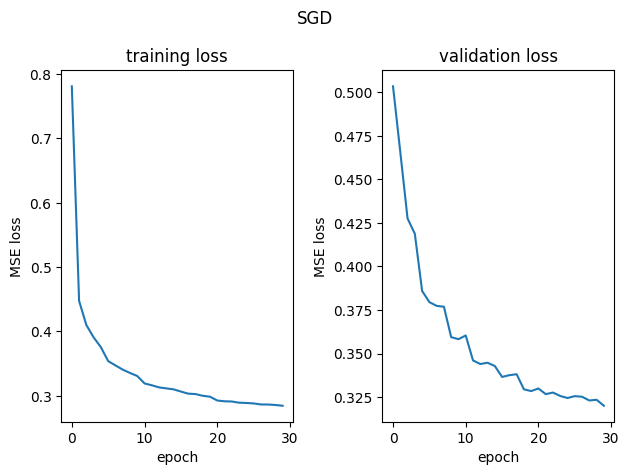

Optimizer: SGD with learning rate: 0.01 and scheduler: CosineAnnealingLR 

-------------------- Epoch 0 --------------------
Average Training Loss for epoch(over all batches) 0.780925343258191
Validation loss for epoch: 0.5033)

-------------------- Epoch 1 --------------------
Average Training Loss for epoch(over all batches) 0.44748659649517686
Validation loss for epoch: 0.4653)

-------------------- Epoch 2 --------------------
Average Training Loss for epoch(over all batches) 0.40913713593200773
Validation loss for epoch: 0.4274)

-------------------- Epoch 3 --------------------
Average Training Loss for epoch(over all batches) 0.3906067774787677
Validation loss for epoch: 0.4179)

-------------------- Epoch 4 --------------------
Average Training Loss for epoch(over all batches) 0.374950179335686
Validation loss for epoch: 0.3861)

-------------------- Epoch 5 --------------------
Average Training Loss for epoch(over all batches) 0.36341313139197573
Validation loss for epoch: 0.3

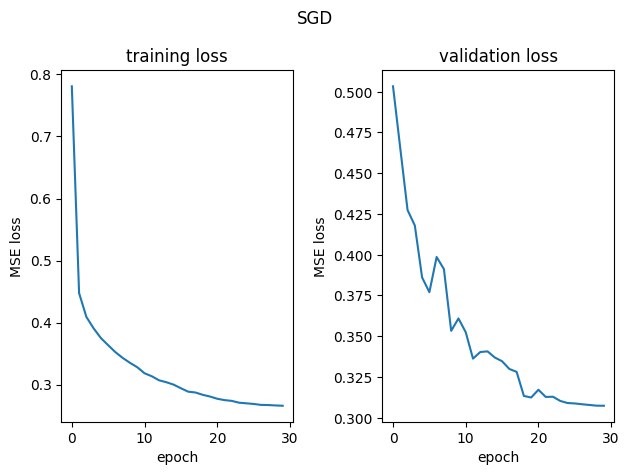

Optimizer: SGD with learning rate: 0.01 and scheduler: CosineAnnealingWarmRestarts 

-------------------- Epoch 0 --------------------
Average Training Loss for epoch(over all batches) 0.780925343258191
Validation loss for epoch: 0.5033)

-------------------- Epoch 1 --------------------
Average Training Loss for epoch(over all batches) 0.4475571279109052
Validation loss for epoch: 0.4653)

-------------------- Epoch 2 --------------------
Average Training Loss for epoch(over all batches) 0.40959224861477855
Validation loss for epoch: 0.4275)

-------------------- Epoch 3 --------------------
Average Training Loss for epoch(over all batches) 0.3900394687280718
Validation loss for epoch: 0.4175)

-------------------- Epoch 4 --------------------
Average Training Loss for epoch(over all batches) 0.37414089676025697
Validation loss for epoch: 0.3880)

-------------------- Epoch 5 --------------------
Average Training Loss for epoch(over all batches) 0.3615639443154884
Validation loss for 

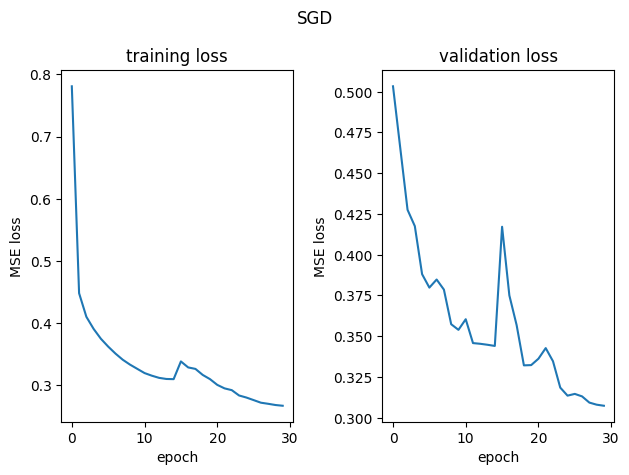

Optimizer: SGD with Momentum with learning rate: 0.01 and scheduler: StepLR 

-------------------- Epoch 0 --------------------
Average Training Loss for epoch(over all batches) 0.6450215612365081
Validation loss for epoch: 0.4600)

-------------------- Epoch 1 --------------------
Average Training Loss for epoch(over all batches) 0.4108790536699569
Validation loss for epoch: 0.3922)

-------------------- Epoch 2 --------------------
Average Training Loss for epoch(over all batches) 0.3729161303655236
Validation loss for epoch: 0.4731)

-------------------- Epoch 3 --------------------
Average Training Loss for epoch(over all batches) 0.3494324017876545
Validation loss for epoch: 0.3647)

-------------------- Epoch 4 --------------------
Average Training Loss for epoch(over all batches) 0.3341543184082329
Validation loss for epoch: 0.3527)

-------------------- Epoch 5 --------------------
Average Training Loss for epoch(over all batches) 0.31319144346743033
Validation loss for epoch: 

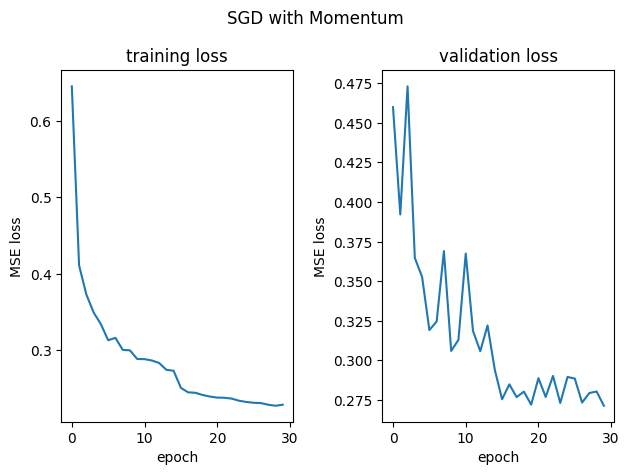

Optimizer: SGD with Momentum with learning rate: 0.01 and scheduler: MultiStepLR 

-------------------- Epoch 0 --------------------
Average Training Loss for epoch(over all batches) 0.6450215612365081
Validation loss for epoch: 0.4600)

-------------------- Epoch 1 --------------------
Average Training Loss for epoch(over all batches) 0.4108790536699569
Validation loss for epoch: 0.3922)

-------------------- Epoch 2 --------------------
Average Training Loss for epoch(over all batches) 0.3729161303655236
Validation loss for epoch: 0.4731)

-------------------- Epoch 3 --------------------
Average Training Loss for epoch(over all batches) 0.3494324017876545
Validation loss for epoch: 0.3647)

-------------------- Epoch 4 --------------------
Average Training Loss for epoch(over all batches) 0.3341543184082329
Validation loss for epoch: 0.3527)

-------------------- Epoch 5 --------------------
Average Training Loss for epoch(over all batches) 0.29562515437405196
Validation loss for ep

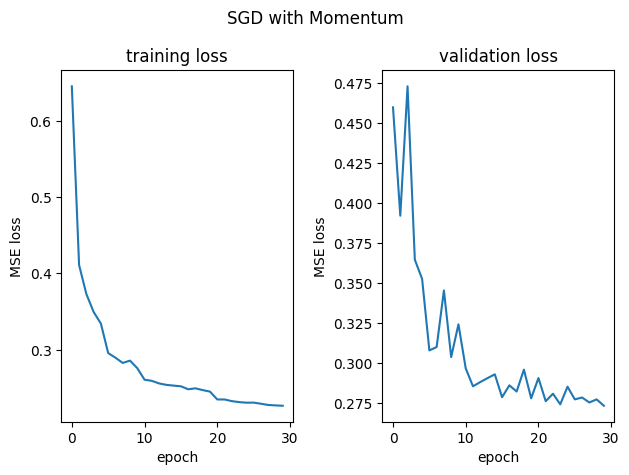

Optimizer: SGD with Momentum with learning rate: 0.01 and scheduler: CosineAnnealingLR 

-------------------- Epoch 0 --------------------
Average Training Loss for epoch(over all batches) 0.6450215612365081
Validation loss for epoch: 0.4600)

-------------------- Epoch 1 --------------------
Average Training Loss for epoch(over all batches) 0.41099871573063124
Validation loss for epoch: 0.3936)

-------------------- Epoch 2 --------------------
Average Training Loss for epoch(over all batches) 0.37348160194645147
Validation loss for epoch: 0.4726)

-------------------- Epoch 3 --------------------
Average Training Loss for epoch(over all batches) 0.34981234478805445
Validation loss for epoch: 0.3671)

-------------------- Epoch 4 --------------------
Average Training Loss for epoch(over all batches) 0.33196374035514564
Validation loss for epoch: 0.3414)

-------------------- Epoch 5 --------------------
Average Training Loss for epoch(over all batches) 0.3125333594801152
Validation lo

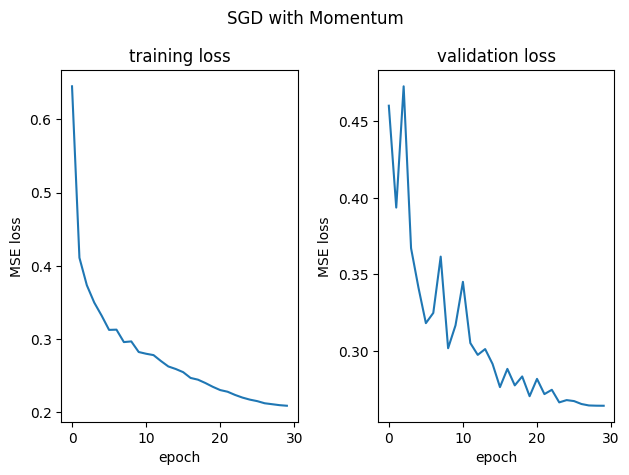

Optimizer: SGD with Momentum with learning rate: 0.01 and scheduler: CosineAnnealingWarmRestarts 

-------------------- Epoch 0 --------------------
Average Training Loss for epoch(over all batches) 0.6450215612365081
Validation loss for epoch: 0.4600)

-------------------- Epoch 1 --------------------
Average Training Loss for epoch(over all batches) 0.4105284408855755
Validation loss for epoch: 0.3924)

-------------------- Epoch 2 --------------------
Average Training Loss for epoch(over all batches) 0.37147049750901956
Validation loss for epoch: 0.4720)

-------------------- Epoch 3 --------------------
Average Training Loss for epoch(over all batches) 0.347171354214702
Validation loss for epoch: 0.3622)

-------------------- Epoch 4 --------------------
Average Training Loss for epoch(over all batches) 0.3282777193472185
Validation loss for epoch: 0.3419)

-------------------- Epoch 5 --------------------
Average Training Loss for epoch(over all batches) 0.307390190562052
Validati

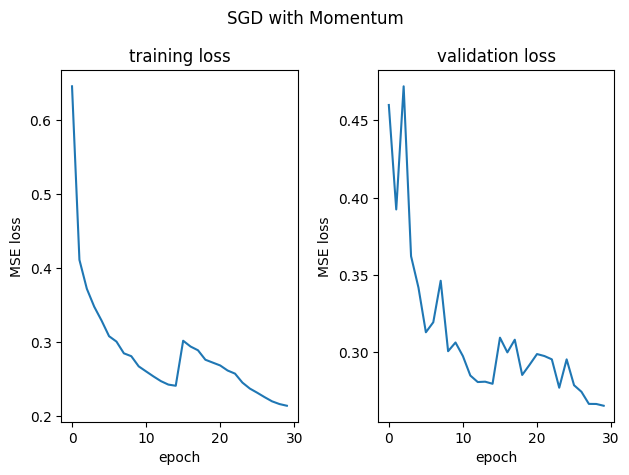

Optimizer: Nesterov SGD with Momentum with learning rate: 0.01 and scheduler: StepLR 

-------------------- Epoch 0 --------------------
Average Training Loss for epoch(over all batches) 0.5608020852756711
Validation loss for epoch: 0.4106)

-------------------- Epoch 1 --------------------
Average Training Loss for epoch(over all batches) 0.3842271064795488
Validation loss for epoch: 0.4297)

-------------------- Epoch 2 --------------------
Average Training Loss for epoch(over all batches) 0.35591551580721825
Validation loss for epoch: 0.3775)

-------------------- Epoch 3 --------------------
Average Training Loss for epoch(over all batches) 0.333905246718663
Validation loss for epoch: 0.3455)

-------------------- Epoch 4 --------------------
Average Training Loss for epoch(over all batches) 0.319195412115845
Validation loss for epoch: 0.3387)

-------------------- Epoch 5 --------------------
Average Training Loss for epoch(over all batches) 0.3047515410369476
Validation loss for 

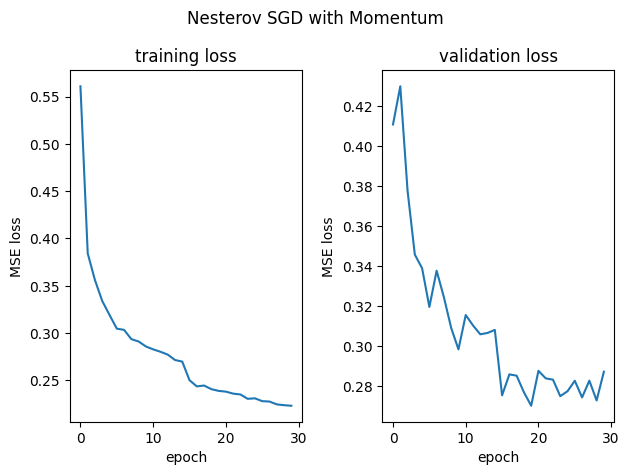

Optimizer: Nesterov SGD with Momentum with learning rate: 0.01 and scheduler: MultiStepLR 

-------------------- Epoch 0 --------------------
Average Training Loss for epoch(over all batches) 0.5608020852756711
Validation loss for epoch: 0.4106)

-------------------- Epoch 1 --------------------
Average Training Loss for epoch(over all batches) 0.3842271064795488
Validation loss for epoch: 0.4297)

-------------------- Epoch 2 --------------------
Average Training Loss for epoch(over all batches) 0.35591551580721825
Validation loss for epoch: 0.3775)

-------------------- Epoch 3 --------------------
Average Training Loss for epoch(over all batches) 0.333905246718663
Validation loss for epoch: 0.3455)

-------------------- Epoch 4 --------------------
Average Training Loss for epoch(over all batches) 0.319195412115845
Validation loss for epoch: 0.3387)

-------------------- Epoch 5 --------------------
Average Training Loss for epoch(over all batches) 0.28790012358036715
Validation los

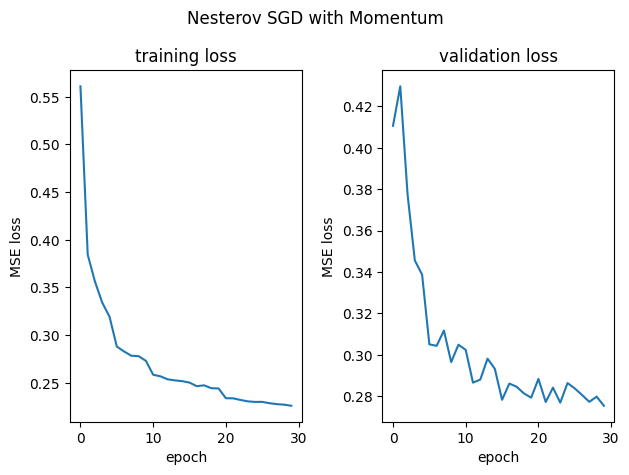

Optimizer: Nesterov SGD with Momentum with learning rate: 0.01 and scheduler: CosineAnnealingLR 

-------------------- Epoch 0 --------------------
Average Training Loss for epoch(over all batches) 0.5608020852756711
Validation loss for epoch: 0.4106)

-------------------- Epoch 1 --------------------
Average Training Loss for epoch(over all batches) 0.38463584269372236
Validation loss for epoch: 0.4277)

-------------------- Epoch 2 --------------------
Average Training Loss for epoch(over all batches) 0.35549367203550264
Validation loss for epoch: 0.3746)

-------------------- Epoch 3 --------------------
Average Training Loss for epoch(over all batches) 0.3334141650558573
Validation loss for epoch: 0.3460)

-------------------- Epoch 4 --------------------
Average Training Loss for epoch(over all batches) 0.3187537415826743
Validation loss for epoch: 0.3379)

-------------------- Epoch 5 --------------------
Average Training Loss for epoch(over all batches) 0.3030426906734969
Valida

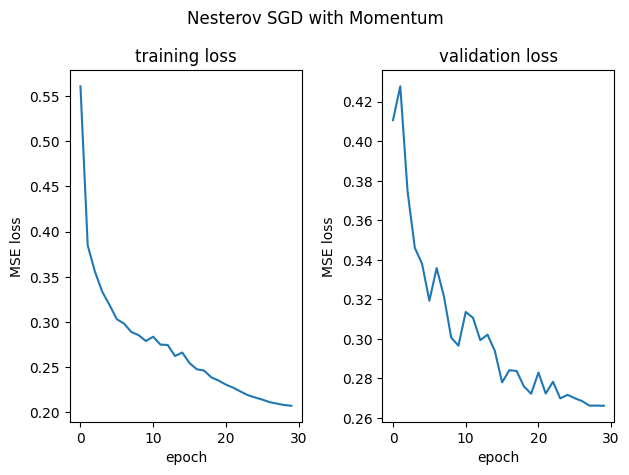

Optimizer: Nesterov SGD with Momentum with learning rate: 0.01 and scheduler: CosineAnnealingWarmRestarts 

-------------------- Epoch 0 --------------------
Average Training Loss for epoch(over all batches) 0.5608020852756711
Validation loss for epoch: 0.4106)

-------------------- Epoch 1 --------------------
Average Training Loss for epoch(over all batches) 0.3840954021377637
Validation loss for epoch: 0.4294)

-------------------- Epoch 2 --------------------
Average Training Loss for epoch(over all batches) 0.35530958367528115
Validation loss for epoch: 0.3831)

-------------------- Epoch 3 --------------------
Average Training Loss for epoch(over all batches) 0.33215285868969113
Validation loss for epoch: 0.3437)

-------------------- Epoch 4 --------------------
Average Training Loss for epoch(over all batches) 0.3149895445831054
Validation loss for epoch: 0.3392)

-------------------- Epoch 5 --------------------
Average Training Loss for epoch(over all batches) 0.2979148620887

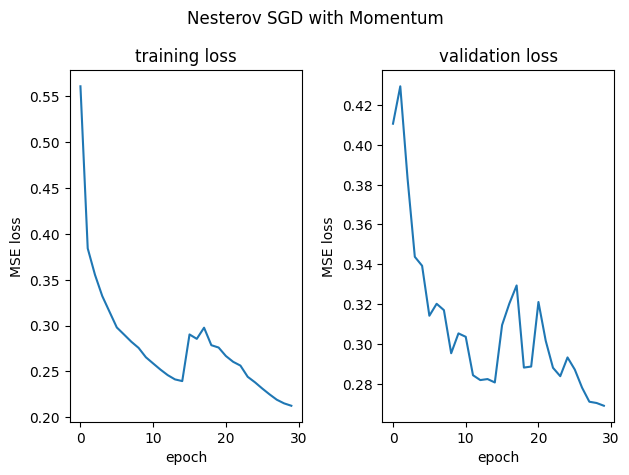

Optimizer: RMSProp with learning rate: 0.01 and scheduler: StepLR 

-------------------- Epoch 0 --------------------
Average Training Loss for epoch(over all batches) 980.6120671845181
Validation loss for epoch: 0.6123)

-------------------- Epoch 1 --------------------
Average Training Loss for epoch(over all batches) 0.4832961970066602
Validation loss for epoch: 0.4809)

-------------------- Epoch 2 --------------------
Average Training Loss for epoch(over all batches) 0.44400800342580915
Validation loss for epoch: 0.4324)

-------------------- Epoch 3 --------------------
Average Training Loss for epoch(over all batches) 0.5577254401503411
Validation loss for epoch: 0.4404)

-------------------- Epoch 4 --------------------
Average Training Loss for epoch(over all batches) 0.4063852903787541
Validation loss for epoch: 0.3734)

-------------------- Epoch 5 --------------------
Average Training Loss for epoch(over all batches) 0.38081368815516475
Validation loss for epoch: 0.3495)

-

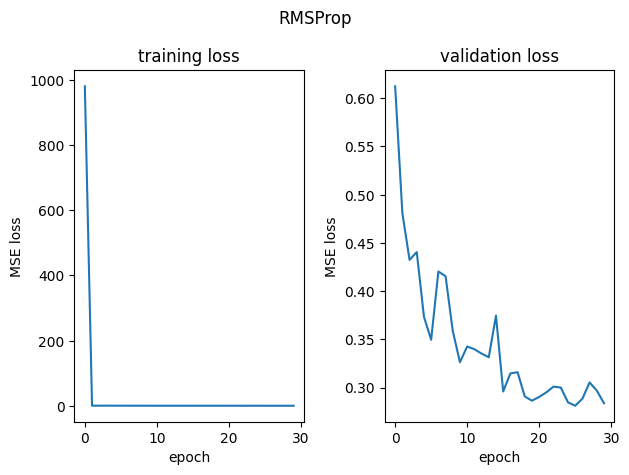

Optimizer: RMSProp with learning rate: 0.01 and scheduler: MultiStepLR 

-------------------- Epoch 0 --------------------
Average Training Loss for epoch(over all batches) 980.6120671845181
Validation loss for epoch: 0.6123)

-------------------- Epoch 1 --------------------
Average Training Loss for epoch(over all batches) 0.4832961970066602
Validation loss for epoch: 0.4809)

-------------------- Epoch 2 --------------------
Average Training Loss for epoch(over all batches) 0.44400800342580915
Validation loss for epoch: 0.4324)

-------------------- Epoch 3 --------------------
Average Training Loss for epoch(over all batches) 0.5577254401503411
Validation loss for epoch: 0.4404)

-------------------- Epoch 4 --------------------
Average Training Loss for epoch(over all batches) 0.4063852903787541
Validation loss for epoch: 0.3734)

-------------------- Epoch 5 --------------------
Average Training Loss for epoch(over all batches) 0.33823096262604263
Validation loss for epoch: 0.328

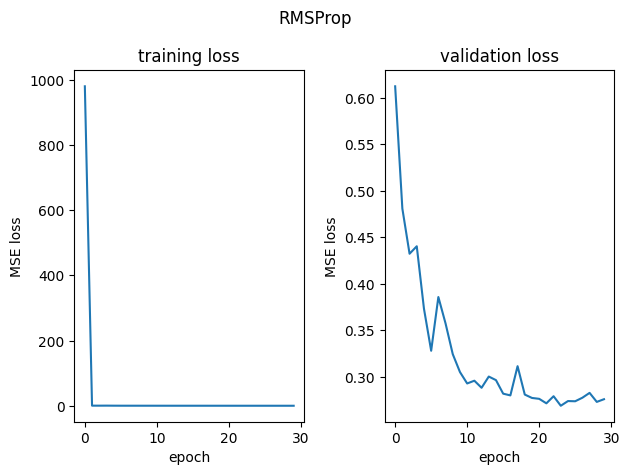

Optimizer: RMSProp with learning rate: 0.01 and scheduler: CosineAnnealingLR 

-------------------- Epoch 0 --------------------
Average Training Loss for epoch(over all batches) 980.6120671845181
Validation loss for epoch: 0.6123)

-------------------- Epoch 1 --------------------
Average Training Loss for epoch(over all batches) 0.48155411580099466
Validation loss for epoch: 0.4823)

-------------------- Epoch 2 --------------------
Average Training Loss for epoch(over all batches) 0.5093234522944003
Validation loss for epoch: 0.4401)

-------------------- Epoch 3 --------------------
Average Training Loss for epoch(over all batches) 0.43342897431117244
Validation loss for epoch: 0.4245)

-------------------- Epoch 4 --------------------
Average Training Loss for epoch(over all batches) 0.41425567433501764
Validation loss for epoch: 0.4224)

-------------------- Epoch 5 --------------------
Average Training Loss for epoch(over all batches) 0.3715938852391148
Validation loss for epoch

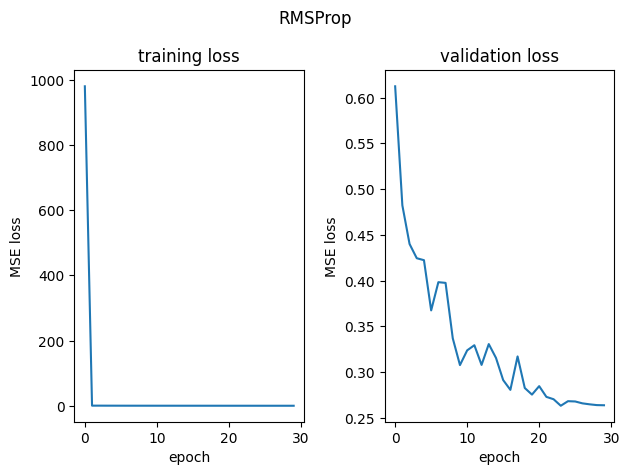

Optimizer: RMSProp with learning rate: 0.01 and scheduler: CosineAnnealingWarmRestarts 

-------------------- Epoch 0 --------------------
Average Training Loss for epoch(over all batches) 980.6120671845181
Validation loss for epoch: 0.6123)

-------------------- Epoch 1 --------------------
Average Training Loss for epoch(over all batches) 0.4822137010308494
Validation loss for epoch: 0.4990)

-------------------- Epoch 2 --------------------
Average Training Loss for epoch(over all batches) 0.45042052987006914
Validation loss for epoch: 0.4410)

-------------------- Epoch 3 --------------------
Average Training Loss for epoch(over all batches) 0.4164928784511522
Validation loss for epoch: 0.4693)

-------------------- Epoch 4 --------------------
Average Training Loss for epoch(over all batches) 0.3898982022748848
Validation loss for epoch: 0.3782)

-------------------- Epoch 5 --------------------
Average Training Loss for epoch(over all batches) 0.35777313567170527
Validation loss 

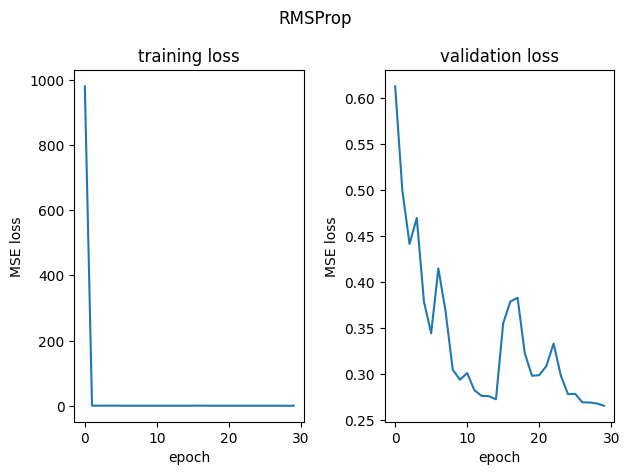

Optimizer: Adam with learning rate: 0.01 and scheduler: StepLR 

-------------------- Epoch 0 --------------------
Average Training Loss for epoch(over all batches) 0.5814325077277896
Validation loss for epoch: 0.4619)

-------------------- Epoch 1 --------------------
Average Training Loss for epoch(over all batches) 0.38756534831384115
Validation loss for epoch: 0.3569)

-------------------- Epoch 2 --------------------
Average Training Loss for epoch(over all batches) 0.3652611490487393
Validation loss for epoch: 0.4648)

-------------------- Epoch 3 --------------------
Average Training Loss for epoch(over all batches) 0.38330612812949494
Validation loss for epoch: 0.3352)

-------------------- Epoch 4 --------------------
Average Training Loss for epoch(over all batches) 0.3211691790647739
Validation loss for epoch: 0.3327)

-------------------- Epoch 5 --------------------
Average Training Loss for epoch(over all batches) 0.311220016313997
Validation loss for epoch: 0.3139)

----

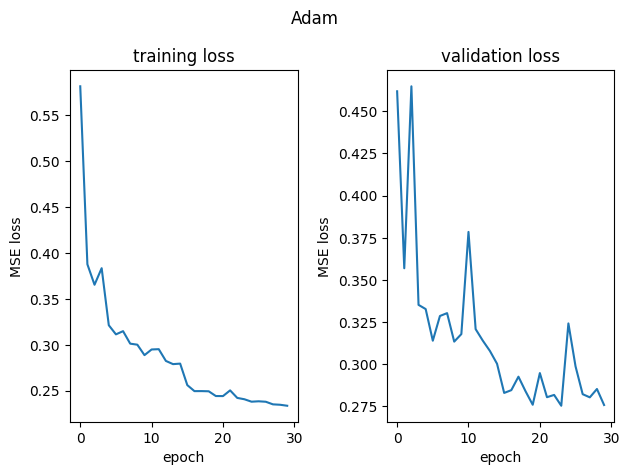

Optimizer: Adam with learning rate: 0.01 and scheduler: MultiStepLR 

-------------------- Epoch 0 --------------------
Average Training Loss for epoch(over all batches) 0.5814325077277896
Validation loss for epoch: 0.4619)

-------------------- Epoch 1 --------------------
Average Training Loss for epoch(over all batches) 0.38756534831384115
Validation loss for epoch: 0.3569)

-------------------- Epoch 2 --------------------
Average Training Loss for epoch(over all batches) 0.3652611490487393
Validation loss for epoch: 0.4648)

-------------------- Epoch 3 --------------------
Average Training Loss for epoch(over all batches) 0.38330612812949494
Validation loss for epoch: 0.3352)

-------------------- Epoch 4 --------------------
Average Training Loss for epoch(over all batches) 0.3211691790647739
Validation loss for epoch: 0.3327)

-------------------- Epoch 5 --------------------
Average Training Loss for epoch(over all batches) 0.2870244209662871
Validation loss for epoch: 0.3124)

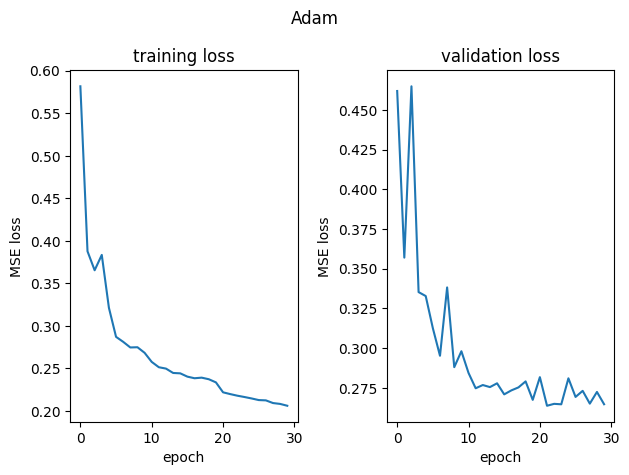

Optimizer: Adam with learning rate: 0.01 and scheduler: CosineAnnealingLR 

-------------------- Epoch 0 --------------------
Average Training Loss for epoch(over all batches) 0.5814325077277896
Validation loss for epoch: 0.4619)

-------------------- Epoch 1 --------------------
Average Training Loss for epoch(over all batches) 0.3893785431849218
Validation loss for epoch: 0.3578)

-------------------- Epoch 2 --------------------
Average Training Loss for epoch(over all batches) 0.35020268617807765
Validation loss for epoch: 0.4827)

-------------------- Epoch 3 --------------------
Average Training Loss for epoch(over all batches) 0.33596257187953565
Validation loss for epoch: 0.3290)

-------------------- Epoch 4 --------------------
Average Training Loss for epoch(over all batches) 0.3665581635998941
Validation loss for epoch: 0.3274)

-------------------- Epoch 5 --------------------
Average Training Loss for epoch(over all batches) 0.3044746596926609
Validation loss for epoch: 0

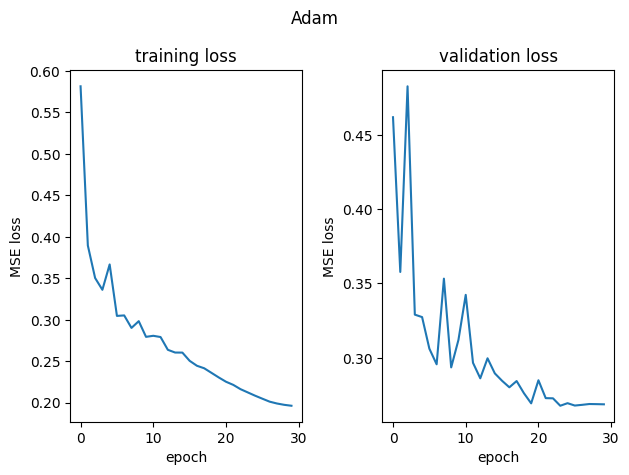

Optimizer: Adam with learning rate: 0.01 and scheduler: CosineAnnealingWarmRestarts 

-------------------- Epoch 0 --------------------
Average Training Loss for epoch(over all batches) 0.5814325077277896
Validation loss for epoch: 0.4619)

-------------------- Epoch 1 --------------------
Average Training Loss for epoch(over all batches) 0.39050511649883957
Validation loss for epoch: 0.3602)

-------------------- Epoch 2 --------------------
Average Training Loss for epoch(over all batches) 0.36364706167209465
Validation loss for epoch: 0.4465)

-------------------- Epoch 3 --------------------
Average Training Loss for epoch(over all batches) 0.36035510673459653
Validation loss for epoch: 0.3347)

-------------------- Epoch 4 --------------------
Average Training Loss for epoch(over all batches) 0.3166139369451367
Validation loss for epoch: 0.3239)

-------------------- Epoch 5 --------------------
Average Training Loss for epoch(over all batches) 0.299261169450407
Validation loss fo

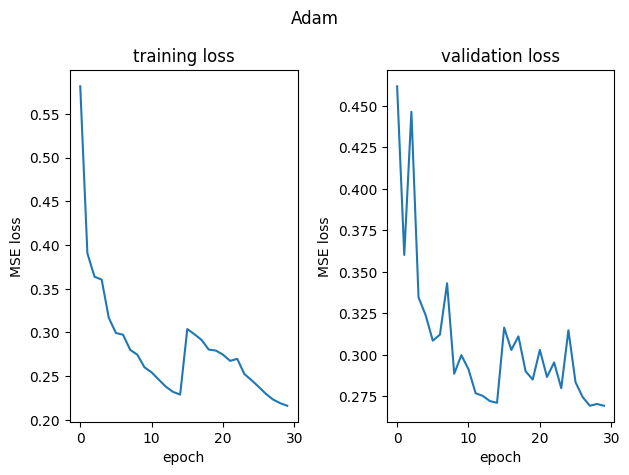

{'optimizer': 'Adam', 'scheduler': 'MultiStepLR', 'lr': 0.005, 'val_loss': np.float64(0.26152706938328535), 'train_loss': np.float64(0.19305862985815095), 'epoch': np.int64(29)}


In [6]:
# best model: NeuralNet_deeper_wide, best epoch: 28, best validation loss: 0.2711376182792723
# best model: NeuralNet_deeper_wide, best epoch: 28, best validation loss: 0.2775191000001639 aktuellstes
from torch.optim.lr_scheduler import StepLR, MultiStepLR, CosineAnnealingLR, CosineAnnealingWarmRestarts
best_model = NeuralNet_deeper_wide()
torch.manual_seed(302); np.random.seed(302) # for safety reasons
lr_rates = [0.001, 0.005, 0.01]

train_val_loss_001 = []
train_val_loss_005 = []
train_val_loss_01 = []

best_combi = {
    'optimizer': None,
    'scheduler': None,
    'lr': None,
    'val_loss': 100,
    'train_loss': None,
    'epoch': None}


schedulers = {
    'StepLR': lambda optimizer: StepLR(optimizer, step_size=15, gamma=0.5),
    'MultiStepLR': lambda optimizer: MultiStepLR(optimizer, milestones=[5, 10, 20], gamma=0.5),
    'CosineAnnealingLR': lambda optimizer: CosineAnnealingLR(optimizer, T_max=30),
    'CosineAnnealingWarmRestarts': lambda optimizer: CosineAnnealingWarmRestarts(optimizer, T_0=15),
}

for lr in lr_rates:
    optimizers = {
        'SGD': lambda params: torch.optim.SGD(params, lr=lr, momentum=0),
        'SGD with Momentum': lambda params: torch.optim.SGD(params, lr=lr, momentum=0.9),
        'Nesterov SGD with Momentum': lambda params: torch.optim.SGD(params, lr=lr, momentum=0.9, nesterov=True),
        'RMSProp': lambda params: torch.optim.RMSprop(params, lr=lr),
        'Adam': lambda params: torch.optim.Adam(params, lr=lr)
    }


    for optimizer_name, optimizer_init_fn in optimizers.items():
        for scheduler_name, scheduler_init_fn in schedulers.items():
            model = best_model
            model.to(device)
            # reinstantiating should reset optimizer parameters
            optimizer = optimizer_init_fn(model.parameters())
            scheduler = scheduler_init_fn(optimizer)

            print(f'Optimizer: {optimizer_name} with learning rate: {lr} and scheduler: {scheduler_name} \n')
            train_loss, val_loss = train_model(model, train_loader, val_loader, device, optimizer=optimizer, num_epochs=30, scheduler=scheduler)
            # val_accuracies_per_optimizer[optimizer_name] = val_accuracies[-1] # save the last accuracy
            print('-'*50)

            # save the best combination for the lowest validation loss, used later then
            if np.min(val_loss) < best_combi['val_loss']:
                best_combi['val_loss'] = np.min(val_loss)
                best_combi['train_loss'] = np.min(train_loss)
                best_combi['optimizer'] = optimizer_name
                best_combi['scheduler'] = scheduler_name
                best_combi['lr'] = lr
                best_combi['epoch'] = np.argmin(val_loss)

            if lr == 0.001:
                train_val_loss_001.append((train_loss[-1], val_loss[-1]))
            elif lr == 0.005:
                train_val_loss_005.append((train_loss[-1], val_loss[-1]))
            elif lr == 0.01:
                train_val_loss_01.append((train_loss[-1], val_loss[-1]))

            fig,axs = plt.subplots(1,2,layout="tight")
            axs[0].plot(train_loss)
            axs[0].set_title("training loss")
            axs[0].set_xlabel("epoch")
            axs[0].set_ylabel("MSE loss")

            axs[1].plot(val_loss)
            axs[1].set_title("validation loss")
            axs[1].set_xlabel("epoch")
            axs[1].set_ylabel("MSE loss")
            plt.suptitle(f"{optimizer_name}")
            plt.show()
            # reset model and optimizer https://www.youtube.com/watch?v=r9tOQ6EKS1Y&ab_channel=deeplizard
            for layer in model.children():
                layer.reset_parameters()

print(best_combi)

In [9]:
# print(train_val_loss_001)
# print(train_val_loss_005)
# print(train_val_loss_01)

[(np.float64(0.26675738845910646), 0.3064510685000837), (np.float64(0.28456775057830114), 0.320061499164218), (np.float64(0.2658402571141456), 0.3073516109193018), (np.float64(0.2662597418292961), 0.30727402527598974), (np.float64(0.2289006603238857), 0.2713595513225526), (np.float64(0.2265926086450968), 0.2734098403424784), (np.float64(0.208975689650505), 0.26438914455580687), (np.float64(0.21341551684535445), 0.2655607173477164), (np.float64(0.22327573902377512), 0.2869649427145686), (np.float64(0.22584291371162488), 0.2753133534196999), (np.float64(0.20724200890852815), 0.26612557089606), (np.float64(0.2125655665696986), 0.26891887834829875), (np.float64(0.23294894145059902), 0.28371929666924717), (np.float64(0.19813953012854388), 0.27607609168239605), (np.float64(0.1940527734701085), 0.2639213821552653), (np.float64(0.20718705979695098), 0.26508040618922885), (np.float64(0.23345849734722776), 0.27579135039320024), (np.float64(0.20605519865598299), 0.2645391387532848), (np.float64(0

## d) Final Training with best parameters

-------------------- Epoch 0 --------------------
Average Training Loss for epoch(over all batches) 0.5124707403436172
-------------------- Epoch 1 --------------------
Average Training Loss for epoch(over all batches) 0.37367656837522456
-------------------- Epoch 2 --------------------
Average Training Loss for epoch(over all batches) 0.3450892511326655
-------------------- Epoch 3 --------------------
Average Training Loss for epoch(over all batches) 0.39278938685898235
-------------------- Epoch 4 --------------------
Average Training Loss for epoch(over all batches) 0.396428813093004
-------------------- Epoch 5 --------------------
Average Training Loss for epoch(over all batches) 0.2933757131672011
-------------------- Epoch 6 --------------------
Average Training Loss for epoch(over all batches) 0.2785818716197942
-------------------- Epoch 7 --------------------
Average Training Loss for epoch(over all batches) 0.2846656443534699
-------------------- Epoch 8 ------------------

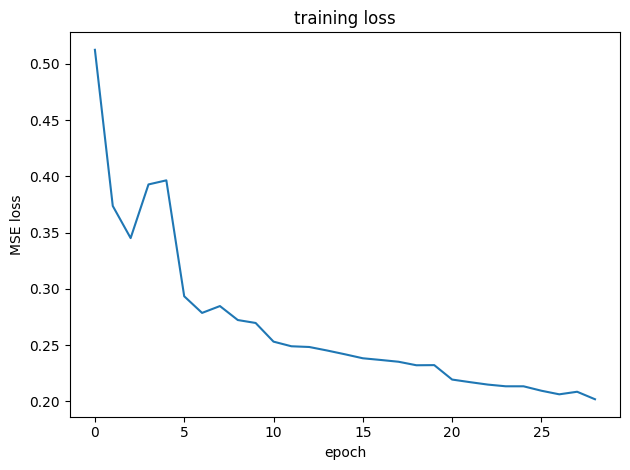

In [10]:
# {'optimizer': 'Adam', 'scheduler': 'MultiStepLR', 'lr': 0.005, 'val_loss': np.float64(0.26152706938328535), 'train_loss': np.float64(0.19305862985815095), 'epoch': np.int64(29)} aktuellstes
final_training_model = NeuralNet_deeper_wide()
final_X_train = torch.concatenate((X_train_torch, X_validation_torch))
final_y_train = torch.concatenate((y_train_torch, y_validation_torch))
final_train_dataset = TensorDataset(final_X_train,final_y_train)
final_train_loader = DataLoader(final_train_dataset, batch_size=32, shuffle=True, worker_init_fn=lambda _: np.random.seed(random_seed))

lr = 0.005
# final_X_train.to(device)
# final_y_train.to(device)

final_optimizer = torch.optim.Adam(final_training_model.parameters(), lr=lr)
# final_scheduler = CosineAnnealingWarmRestarts(final_optimizer, T_0=15)
final_scheduler = MultiStepLR(final_optimizer, milestones=[5, 10, 20], gamma=0.5)

train_loss, val_loss = train_model(final_training_model, final_train_loader, device=device, optimizer=final_optimizer, num_epochs=29, scheduler=final_scheduler)
# val_accuracies_per_optimizer[optimizer_name] = val_accuracies[-1] # save the last accuracy
print('-'*50)

# save the best combination for the lowest validation loss, used later then

fig2,axs = plt.subplots(1,1,layout="tight")
axs.plot(train_loss)
axs.set_title("training loss")
axs.set_xlabel("epoch")
axs.set_ylabel("MSE loss")
plt.show()
fig2.savefig("./plots/final_train.png")


In [11]:
print(f"final_training_loss = {train_loss[-1]}")

final_trianing_loss = 0.20183166814061393


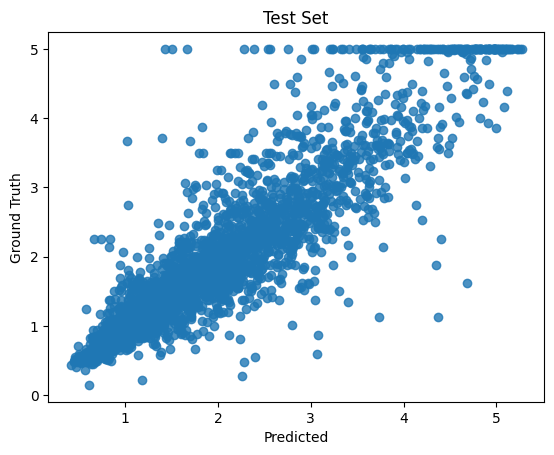

final test loss = 0.2617280185222626


In [12]:
# Test
final_training_model.to(device) # Set model to gpu
final_training_model.eval()
X_test_torch = X_test_torch.to(device)
y_test_torch = y_test_torch.to(device)
loss_fn = nn.MSELoss()
# Run forward pass
with torch.no_grad():
  pred = final_training_model(X_test_torch)
loss = loss_fn(y_test_torch, pred)

fig3 = plt.figure()
plt.scatter(pred.cpu(), y_test_torch.cpu(), alpha=0.8)
plt.ylabel("Ground Truth")
plt.xlabel("Predicted")
plt.title("Test Set")
plt.show()
print(f"final test loss = {loss}")
fig3.savefig("./plots/scatter.png")


## f) Binary Classification

In [5]:
from models import NeuralNet_deeper_wide_classification
from torch.optim.lr_scheduler import MultiStepLR

#combine training data back together with validation data
X_train_norm = normalized_sets[0]
X_val_norm = normalized_sets[1]
X_test_norm = normalized_sets[2]

device = 'cuda' if torch.cuda.is_available() else 'cpu'

X_train_recombined = np.concatenate((X_train_norm, X_val_norm), axis=0)
y_train_recombined = np.concatenate((y_train, y_validation),axis=0)

y_train_recombined_class = y_train_recombined.copy()
y_test_class = y_test.copy()
y_train_recombined_class[y_train_recombined < 2], y_test_class[y_test < 2] = 0., 0.
y_train_recombined_class[y_train_recombined >= 2], y_test_class[y_test >= 2] = 1., 1.


#
# ##########################################################
#
#
X_train_torch = torch.tensor(X_train_recombined,dtype=torch.float32)
y_train_torch = torch.tensor(y_train_recombined_class.reshape((len(y_train_recombined_class),1)),dtype=torch.float32)
X_test_torch = torch.tensor(X_test_norm,dtype=torch.float32)
y_test_torch = torch.tensor(y_test_class.reshape((len(y_test),1)),dtype=torch.float32)

train_dataset = torch.utils.data.TensorDataset(X_train_torch,y_train_torch)
test_dataset = torch.utils.data.TensorDataset(X_test_torch,y_test_torch)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True, worker_init_fn=lambda _: np.random.seed(random_seed))
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=True, worker_init_fn=lambda _: np.random.seed(random_seed))
# #########################################################
#
loss_fn = nn.NLLLoss()


#Create the full model(NN, optimizer, scheduler), depending on what performed best
best_learning_rate = 0.005
best_num_epochs = 30
best_model = NeuralNet_deeper_wide_classification().to(device)
best_optimizer = torch.optim.Adam(best_model.parameters(), lr=best_learning_rate)
best_scheduler = MultiStepLR(best_optimizer, milestones=[5, 10, 20], gamma=0.5)

avg_training_losses = []
test_losses = []
test_accuracies = []

for epoch in range(1,best_num_epochs+1):# one loop over the dataset = 1 epoch
    print('-'*20, f'Epoch {epoch}', '-'*20)
    # Train one epoch
    best_model.train() #> setting model to "train mode", because some layers act different in training or evaluation
    losses = []
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        data = data.float()
        target = target.float()

        best_optimizer.zero_grad()#needed, because otherwise the new gradients would get summed onto the old ones
        # the sum would be useful e.g. for CNNs

        log_probs = torch.squeeze(best_model(data))# log probabilities of batch
        target = torch.squeeze(target.long())
        loss = loss_fn(log_probs, target)
        loss.backward()
        best_optimizer.step()

        losses.append(loss.item())
        # if batch_idx % 100 == 0:
        #     print(f'Train Epoch {epoch} | Loss: {loss.item()}')
    best_scheduler.step()
    avg_train_loss = np.mean(losses[-len(train_loader):])
    avg_training_losses.append(avg_train_loss)
    print(f'\nAverage train loss in epoch {epoch}: {avg_train_loss}')
    
    # Evaluate on test set
    best_model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            data = data.float()
            target = target.float()
            log_probs = torch.squeeze(best_model(data))
            target = torch.squeeze(target.long())
            
            test_loss += F.nll_loss(log_probs, target, reduction='sum').item()  # sum up batch loss
            pred = torch.argmax(log_probs, dim=1)  # get the index of the max log-probability
            correct += (pred == target).sum().item()

    test_loss /= len(test_loader.dataset)
    avg_correct = correct / len(test_loader.dataset)

    test_losses.append(test_loss)
    test_accuracies.append(avg_correct)

    print(f'Test set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} ({100. * avg_correct:.0f}%)\n')


-------------------- Epoch 1 --------------------

Average train loss in epoch 1: 0.3811751964213574
Test set: Average loss: 0.3583, Accuracy: 2184/2580 (85%)

-------------------- Epoch 2 --------------------

Average train loss in epoch 2: 0.3297137293008576
Test set: Average loss: 0.3416, Accuracy: 2183/2580 (85%)

-------------------- Epoch 3 --------------------

Average train loss in epoch 3: 0.31550512229446814
Test set: Average loss: 0.3324, Accuracy: 2207/2580 (86%)

-------------------- Epoch 4 --------------------

Average train loss in epoch 4: 0.310825001784658
Test set: Average loss: 0.3115, Accuracy: 2220/2580 (86%)

-------------------- Epoch 5 --------------------

Average train loss in epoch 5: 0.30007655970026964
Test set: Average loss: 0.3016, Accuracy: 2218/2580 (86%)

-------------------- Epoch 6 --------------------

Average train loss in epoch 6: 0.28450185165996045
Test set: Average loss: 0.2893, Accuracy: 2236/2580 (87%)

-------------------- Epoch 7 ---------

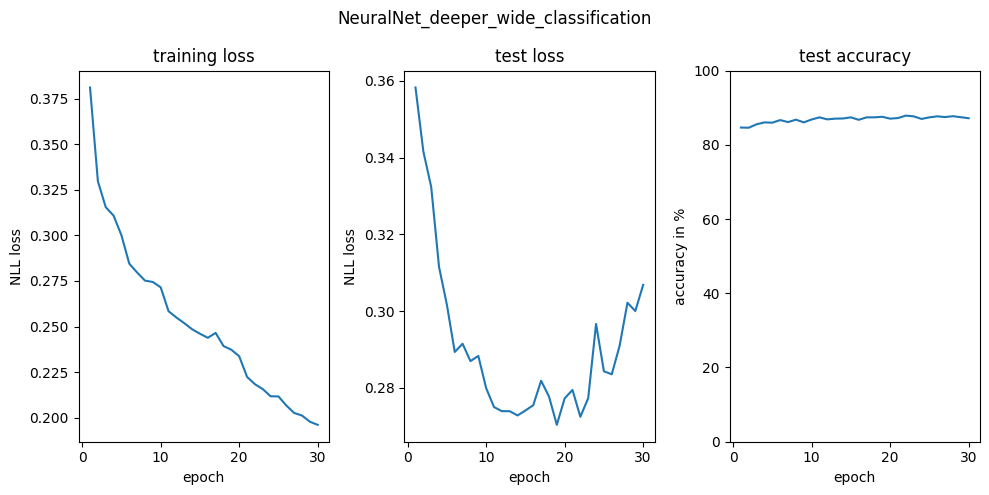

In [6]:
fig1,axs = plt.subplots(1,3,layout="tight",figsize = (10,5))
axs[0].plot(np.linspace(1,len(avg_training_losses),len(avg_training_losses)),avg_training_losses)
axs[0].set_title("training loss")
#axs[0].set_ylim([0.28,max(avg_training_losses)])
axs[0].set_xlabel("epoch")
axs[0].set_ylabel("NLL loss")

axs[1].plot(np.linspace(1,len(test_losses),len(test_losses)),test_losses)
axs[1].set_title("test loss")
#axs[1].set_ylim([0.28,max(test_losses)])
axs[1].set_xlabel("epoch")
axs[1].set_ylabel("NLL loss")

axs[2].plot(np.linspace(1,len(test_accuracies),len(test_accuracies)), [100*acc for acc in test_accuracies])
axs[2].set_title("test accuracy")
axs[2].set_ylim([0,100])
axs[2].set_xlabel("epoch")
axs[2].set_ylabel("accuracy in %")
plt.suptitle(f"{best_model._get_name()}")
plt.show()
fig1.savefig("./plots/binary_classification_test_evaluation.png")

In [7]:
print(f"final training loss: {avg_training_losses[-1]}")
print(f"final test loss: {test_losses[-1]}")
print(f"final test accuracy: {test_accuracies[-1]}")

final training loss: 0.1960668275182226
final test loss: 0.30681519037069277
final test accuracy: 0.8717054263565891
